## Copyright

In [1]:
# ########################################################################### #
#    Copyright (c) 2019-2023, California Institute of Technology.
#    All rights reserved.  Based on Government Sponsored Research under
#    contracts NNN12AA01C, NAS7-1407 and/or NAS7-03001.
#
#    Redistribution and use in source and binary forms, with or without
#    modification, are permitted provided that the following conditions
#    are met:
#      1. Redistributions of source code must retain the above copyright
#         notice, this list of conditions and the following disclaimer.
#      2. Redistributions in binary form must reproduce the above copyright
#         notice, this list of conditions and the following disclaimer in
#         the documentation and/or other materials provided with the
#         distribution.
#      3. Neither the name of the California Institute of
#         Technology (Caltech), its operating division the Jet Propulsion
#         Laboratory (JPL), the National Aeronautics and Space
#         Administration (NASA), nor the names of its contributors may be
#         used to endorse or promote products derived from this software
#         without specific prior written permission.
#
#    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
#    "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
#    LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
#    A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE CALIFORNIA
#    INSTITUTE OF TECHNOLOGY BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
#    SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED
#    TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
#    PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF
#    LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING
#    NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
#    SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
# ########################################################################### #
#    EXOplanet Transit Interpretation Code (EXOTIC)
#    # NOTE: See companion file version.py for version info.
# ########################################################################### #
# ########################################################################### #
# Exoplanet light curve analysis
#
# Fit an exoplanet transit model to time series data.
# ########################################################################### #


<div>
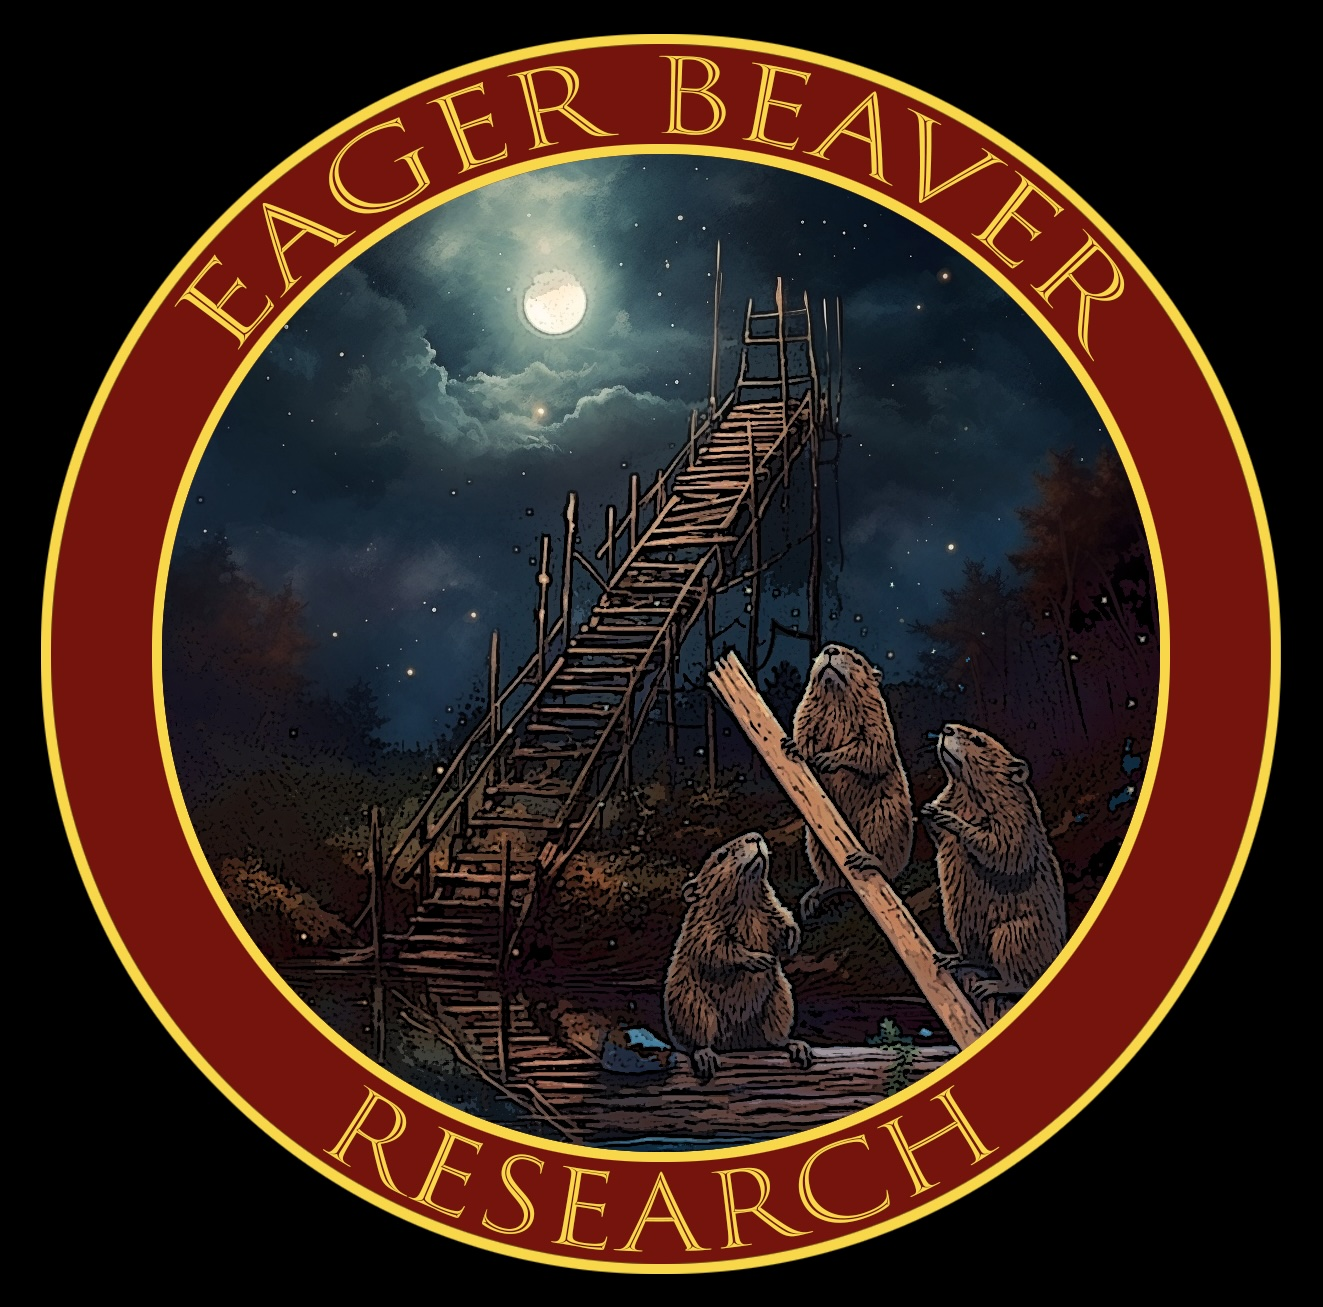
    ASU SESE members: Suber Corley, Fred Noguer, Bradley Hutson, Molly Simon
</div>

<div>
<img src="attachment:Eager_Beaver_Research_Logo.jpg" width="200"/>
</div>

pip install --upgrade uncertainties

In [2]:
# import time 
# this code is executed solely to record accurately the run time for this notebook
import time
start_time = time.time()

## Imports

In [3]:
import copy
import pickle
import numpy as np
from itertools import cycle
from astropy.time import Time
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from pylightcurve.models.exoplanet_lc import eclipse_mid_time, transit_flux_drop
from ultranest import ReactiveNestedSampler
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from scipy import stats
from copy import deepcopy
import glob

from math import sin,cos,tan,asin,acos,atan,radians,degrees,pi,log
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

import os
import fnmatch
import pandas as pd
import matplotlib as mpl
import plotly
import plotly.express as px

from itertools import cycle
from dace_query.spectroscopy import Spectroscopy
from statistics import mean
from astropy.io import fits
from datetime import datetime

    Done!
Checking exotethys database...
Checking ephemerides database...
Checking photometry database...
Checking catalogues database...


In [4]:
# for rv_fitter.py
import sys
# caution: path[0] is reserved for script path
sys.path.insert(1, '/Users/subercorley/EXOTIC/exotic/api')
from rv_fitter import rv_fitter
from rvfitter_elca import glc_fitter, lc_fitter
from rvmapper import RV_Mapper
import plotting

In [5]:
# this program log is used to record and retain information regarding the execution of this notebook
today = datetime.today().strftime('%Y%m%d%H%M')
logname = 'jointfitlog'+today+'.txt'
startstring = 'begin log for '+today
with open(logname, 'w') as joint_log:
	joint_log.write(startstring)

## Settings
### All variables should be established in Settings and not modified or set elsewhere in the code

In [6]:
AU = const.au.to(u.m).value
Mjup = const.M_jup.to(u.kg).value
Msun = const.M_sun.to(u.kg).value
Rsun = const.R_sun.to(u.m).value
Grav = const.G.to(u.m**3/u.kg/u.day**2).value

# ########################################################################### #
# Values in this section drive the extraction and standardization of observational Radial Velocity data

## Target
# Within the RV_Mapper function that is invoked in this notebook, the "target" is used to confirm that radial
# velocity observations are related to the system being studied. It is also used to access SIMBAD in order to 
# retrieve the Right Ascenscion (RA) and Declination (Dec) of the target. The RA and Dec are used where possible
# to locate the observations since there are many aliases of target name that can confuse and make locating 
# observations difficult.
#
# EagerBeavers COMMENT: Be careful to place the correct target name in all three of the positions identified
# here:

target = 'HAT-P-23'             # as used to search for the target in observation data
target_planet = 'HAT-P-23 b'    # as target_planet name for display purposes
# the target name can be approximated when searching the Exoplanet Archive
result_table = NasaExoplanetArchive.query_criteria(table="pscomppars", where="hostname like 'HAT-P-23%'")

# Stellar parameters pulled from the Exoplanet Archive
print("result table ",result_table)
print('stellar host name ',result_table['hostname']) 
print('stellar radial velocity ',result_table['st_radv'])
print('stellar density ',result_table['st_vsin'])
print('stellar rotational velocity ',result_table['st_vsin'])
print('stellar effective temp ',result_table['st_teff'])
print('stellar radius ',result_table['st_rad'])
print('stellar mass ',result_table['st_mass'])
print('stellar age ',result_table['st_age'])

# TESS File absolute address. This file contains the TESS data for this target only.

tessfileaddress = '/Users/subercorley/Kyle_HAT_P_23_textfiles/*_hatp23b_AAVSO.txt'

## Instruments
# set an empty array for the instruments from which observations will be successfully collected
instruments=[]

## Indicators
# stellar activity indicators are used to detect effects on radial velocity that could cause false positives
# for planetary perturbations
indicators = ['rhk']            # rhk is the default

## rhk_value
# rhk has been chosen as a default. If another activity indicator is present for the instrument chosen,
# the code must be modified in this notebook and the RV_Mapper
rhk_value = 3.00                # this value should be set to the published value for the star, if known

# other stellar activity indicators are:
# indicators = ['sindex']
# indicators = ['haindex']
# indicators = ['bispan']
# indicators = ['fwhm']
# indicators = ['contrast']
# indicators = ['rhk']
# if an indicator is chosen and is not present in the data for an instrument collected, the code will fail

## Choosing Radial Velocity Source instruments

## DACE API interface to DACE Spectroscopy database
# "This document makes use of tools and resources from the Data & Analysis Center for Exoplanets (DACE), which is
# a facility based at the University of Geneva (CH) dedicated to extrasolar planets data visualisation, exchange
# and analysis. DACE is a platform of the Swiss National Centre of Competence in Research (NCCR) PlanetS, 
# federating the Swiss expertise in Exoplanet research. 
# The DACE platform is available at https://dace.unige.ch."
#
# EagerBeavers COMMENT:
# For anyone using data compiled from DACE, the facility requests the above language in acknowledgement.
# The DACE Spectroscopy API is used to extract RV data from the DACE Spectroscopy database. 
# The DACE Spectroscopy database is a good source that contains radial velocity data from many discovery papers. 
# It is not completely comprehensive and the data in the database depends upon the data made available at the time
# that it was made available to the DACE team. This may not map completely to the data that is described in the
# discovery paper.

dace=True                # This is set to "True" to access DACE and "False", otherwise.

## Keck-HIRES 2017 .csv file
# "The LCES HIRES/Keck Precision Radial Velocity Exoplanet Survey" 
# (https://ui.adsabs.harvard.edu/abs/2017AJ....153..208B)  provides a link to the compilation of Keck-HIRES
# radial velocity data by R.P. Butler et al. which was published in 2017.
#
# EagerBeavers COMMENT: The 2017 Keck-HIRES data was compiled by Butler et al into a flat file that is stored
# in the directory along with this notebook as HIRES_Keck_Precision_Radial_Velocity_Exoplanet_Survey.csv. We have
# used this resource for limited purposes as the authors of the study described in the paper mentioned above
# were selective in the targets that are included in the survey and our requirements for targets have not usually
# been met.

butler_2017=True         # This is set to "True" to access HIRES 2017 and "False", otherwise.

## Keck-HIRES 2020 folder
# The Carnegie Science/EPS website (https://ebps.carnegiescience.edu/home) supplied an updated version of the
# HIRES 2017 radial velocity data as a collection of files.
# 
# EagerBeavers COMMENT: The Carnegie Science version was not published but we downloaded it and provide it here
# as a directory of files named keck_vels which is in the directory with this notebook. This updated version is
# not a complete replacement for the 2017 version and has the same limits on the targets that were made available.

butler_2020=True        # This is set to "True" to access HIRES 2020 and "False", otherwise.


## HARPS library
# In December 2023, the European Southern Observatory (ESO) announced 
# (https://www.eso.org/sci/observing/phase3/news.html) the release of a new library 
# (https://doi.eso.org/10.18727/archive/33) which contains the radial velocity for the first 20 years of the
# La Silla (pron.: lah see-yah) telescope's HARPS instrument. The release document includes instruction on the unbundling of these
# observations:
#
# EagerBeaver COMMENT: The library of HARPS observations are stored in the directory along with this notebook and
# is a flat file named: ADP.2023-12-04T15_16_53.464.fits.

eso_harps=True          # This is set to "True" to access the HARPS library of RV data and "False", otherwise.

## ESPRESSO .fits headers
# ESO hosts a website (https://www.eso.org/sso/login). The entire online database for the ESPRESSO instrument
# which is hosted by the Very Large Telescope at Cerro Paranal was downloaded from this web-site. 
# The download consists of a main directory and a sub-directory called Archive.
# In the archive are a number of .fits files that have headers with the data that defines the radial velocity, 
# the RV uncertainty, the date of the observation and other information about stellar activity that are useful
# in RV analysis for exoplanets. 
#
# EagerBeavers COMMENT: The directory called ESPRESSO_Full_Data_Set is as described above and it sits in the same
# directory as this notebook. To detect observations for a given target, the RV_Mapper code opens each .fits file
# and confirms that the RA and DEC values agree with those defined for the target. The ESPRESSO RV observations are
# very high resolution but searching through the directory and the associated fits files is more time consuming than
# the searches through the data belonging to other instruments.

eso_espresso=True       # This is set to "True" to access the ESPRESSO files of RV data and "False", otherwise.

## SOPHIE high resolution spectroscopy
# The SOPHIE spectrograph is hosted at the Observatoire de Haute-Provence in southern France. Spectroscopic data
# from SOPHIE is stored at an archive and is available on-line (http://atlas.obs-hp.fr/sophie/).
#
# EagerBeaver COMMENT: The entire database from SOPHIE was downloaded into a flat file "sophiecc_1686978863.txt".
# A number of exoplanet discoveries have been supported with RV data from SOPHIE. Though it is classified as a
# high-resolution spectrograph, its resolution is less than the ESO instruments at La Silla.
# We have also experienced noisy signals from SOPHIE that have required that we not include the SOPHIE data in our
# work. From communications with the SOPHIE team, we understand that not all SOPHIE data has been cleared by data
# quality checks.

sophie=True              # This is set to "True" to access the SOPHIE file of RV data and "False", otherwise.

## trimming and removing unwanted observations
# A trim function is available in RV_Mapper that allows unwanted observations to be removed. There are several
# parameters that are passed to RV_Mapper that control this function.

trim=False              # Must be set to True to allow any of the trim limits to apply.

trim_lower=00000.0      # Any observations with rjd dates less than the trim_lower value will be removed.
                        # A value of 00000.0 means that no observations will be removed.
trim_upper=99999.9      # Any observations with rjd dates more than the trim_lower value will be removed.
                        # A value of 99999.9 means that no observations will be removed.

# The bounded dates below are used to de-select observations based on rjd date.
# Lower bound is on the left and upper bound is on the right of each pair
# To ensure smooth running, exchange these values for 0's but leave the table in place

remove_date_ranges = [[55432.0,55435.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0]]

# Individual dates of observations that are to be de-selected. Must be a comma separated list inside the square
# brackets.
# To ensure smooth running, exchange these values for 0's but leave the table in place

remove_date_singles = [0.0]

# gamma is the Systemic Radial Velocity, that is, the velocity with which the stellar system is moving with 
# respect to a terrestrial observer. The value is obtained by way of the NASA ExoplanetWatch API, which was
# executed previously in Settings. 

cell_value=str(result_table[0]["st_radv"])
cell_value_split=cell_value.split()
gamma=float(cell_value_split[0])

# observational sources may show a variance from gamma
# the gamma offset is an arbitrary change to the accepted gamma value to visually align the observed data

gamma_offset = 0.7      # change this value as needed, see comment above
gamma=gamma + gamma_offset
print('gamma ',gamma, ' km / s')

clip_snr = 30.0         # This is the low bar for acceptable signal to noise ratios. 
                        # That is: (radial velocity/radial velocity uncertainties).

# end of variable setting for Radial Velocity observations

# ########################################################################### #


save_myfit_lc_parameters = []
save_myfit_lc_errors = []

result table   pl_name   pl_letter hostname ...   htm20         sky_coord       
                              ...                  deg,deg        
---------- --------- -------- ... --------- ----------------------
HAT-P-23 b         b HAT-P-23 ... -64879224 306.1239076,16.7621462
stellar host name  hostname
--------
HAT-P-23
stellar radial velocity  [-15.1] km / s
stellar density  [8.1] km / s
stellar rotational velocity  [8.1] km / s
stellar effective temp  [5905.] K
stellar radius  [1.2] Rsun
stellar mass  [1.13] Msun
stellar age  [4.] Gyr
gamma  -14.4  km / s


UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]
UnitTypeError("MaskedQuantity instances require normal units, not <class 'astropy.units.function.logarithmic.DexUnit'> instances.") [astropy.table.table]


In [7]:
  

def planet_orbit(period, sma_over_rs, eccentricity, inclination, periastron, mid_time, time_array, ww=0, mu=1, W=0):
    # please see original: https://github.com/ucl-exoplanets/pylightcurve/blob/master/pylightcurve/models/exoplanet_lc.py
#    print("BOOM MAIN Method:planet_orbit")
    inclination = inclination * np.pi / 180.0
    periastron = periastron * np.pi / 180.0
    ww = ww * np.pi / 180.0
    W = W * np.pi / 180.0

    if eccentricity == 0 and ww == 0:
        vv = 2 * np.pi * (time_array - mid_time) / period
        bb = sma_over_rs * np.cos(vv)
        return [mu*bb * np.sin(inclination), mu*sma_over_rs * np.sin(vv), - bb * mu*np.cos(inclination)]

    if periastron < np.pi / 2:
        aa = 1.0 * np.pi / 2 - periastron
    else:
        aa = 5.0 * np.pi / 2 - periastron
    bb = 2 * np.arctan(np.sqrt((1 - eccentricity) / (1 + eccentricity)) * np.tan(aa / 2))
    if bb < 0:
        bb += 2 * np.pi
    mid_time = float(mid_time) - (period / 2.0 / np.pi) * (bb - eccentricity * np.sin(bb))
    m = (time_array - mid_time - np.int_((time_array - mid_time) / period) * period) * 2.0 * np.pi / period
    u0 = m
    stop = False
    u1 = 0
    for ii in range(10000):  # setting a limit of 1k iterations - arbitrary limit
        u1 = u0 - (u0 - eccentricity * np.sin(u0) - m) / (1 - eccentricity * np.cos(u0))
        stop = (np.abs(u1 - u0) < 10 ** (-6)).all()
        if stop:
            break
        else:
            u0 = u1
    if not stop:
        raise RuntimeError('Failed to find a solution in 10000 loops')

    vv = 2 * np.arctan(np.sqrt((1 + eccentricity) / (1 - eccentricity)) * np.tan((u1) / 2))
    rr = mu*sma_over_rs * (1 - (eccentricity ** 2)) / (np.ones_like(vv) + eccentricity * np.cos(vv+W))

    aa = np.cos(vv + periastron)
    bb = np.sin(vv + periastron)

    x = rr * bb * np.sin(inclination)
    y = rr * (-aa * np.cos(ww) + bb * np.sin(ww) * np.cos(inclination))
    z = rr * (-aa * np.sin(ww) - bb * np.cos(ww) * np.cos(inclination))

    return [x, y, z]

def pytransit(limb_darkening_coefficients, rp_over_rs, period, sma_over_rs, eccentricity, inclination, periastron,
            mid_time, time_array, method='claret', precision=3):
#    print("BOOM MAIN Method:pytransit")
    position_vector = planet_orbit(period, sma_over_rs, eccentricity, inclination, periastron, mid_time, time_array)

    projected_distance = np.where(
        position_vector[0] < 0, 1.0 + 5.0 * rp_over_rs,
        np.sqrt(position_vector[1] * position_vector[1] + position_vector[2] * position_vector[2]))

    return transit_flux_drop(limb_darkening_coefficients, rp_over_rs, projected_distance,
                             method=method, precision=precision)

def transit(times, values):
#    print("BOOM MAIN Method:transit")
    model = pytransit([values['u0'], values['u1'], values['u2'], values['u3']], 
                    values['rprs'], values['per'], values['ars'], 
                    values['ecc'], values['inc'], values['omega'],
                    values['tmid'], times, method='claret', precision=3)
    return model

from pylightcurve.models.exoplanet_lc import transit as pytransit
from pylightcurve.models.exoplanet_lc import eclipse_mid_time

#def eclipse(times, values):
#    print("BOOM MAIN Method:eclipse")
#    tme = eclipse_mid_time(values['per'], values['ars'], values['ecc'], values['inc'], values['omega'], values['tmid'])
#    model = pytransit([0,0,0,0], 
#                    values['rprs']*values['fpfs']**0.5, values['per'], values['ars'], 
#                    values['ecc'], values['inc'], values['omega']+180,
#                    tme, times, method='quad', precision=3)
#    return model + values['fpfs']*values['rprs']**2 # second part is eclipse depth

def get_phase(times, per, tmid):
#    print("BOOM MAIN Method:get_phase")
    return (times - tmid + 0.25 * per) / per % 1 - 0.25

#def phasecurve(times, values):
#    print("BOOM MAIN Method:phasecurve")
#    tme = eclipse_mid_time(values['per'], values['ars'], values['ecc'], values['inc'], values['omega'], values['tmid'])
#    edepth = values['fpfs']*values['rprs']**2 # eclipse depth
#    emodel = pytransit([0,0,0,0], 
#                    edepth**0.5, values['per'], values['ars'], 
#                    values['ecc'], values['inc'], values['omega']+180,
#                    tme, times, method='quad', precision=3)
#    tmodel = pytransit([values['u1'], values['u2'], 0, 0], 
#                    values['rprs'], values['per'], values['ars'], 
#                    values['ecc'], values['inc'], values['omega'],
#                    values['tmid'], times, method='quad', precision=3)
#    c0 = edepth - values['c1'] - values['c3']
#    brightness = 1 + c0 + values['c1']*np.cos(2*pi*(times-tme)/values['per']) + values['c2']*np.sin(2*pi*(times-tme)/values['per']) + values['c3']*np.cos(4*pi*(times-tme)/values['per']) + values['c4']*np.sin(4*pi*(times-tme)/values['per'])
#    emask = np.floor(emodel)
#    return (brightness*(emask) + (edepth+emodel)*(1-emask))*tmodel

def rv_model(time, params, dt=0.0001):
#    print("BOOM MAIN Method:rv_model")
    xp,yp,zp = planet_orbit(params['per'], params['ars'], params['ecc'], 
                            params['inc'], params['omega'], params['tmid'], 
                            time, mu=1, ww=0)
    # TODO optimize by only computing in X direction
    xp2,yp2,zp2 = planet_orbit(params['per'], params['ars'], params['ecc'],
                            params['inc'], params['omega'], params['tmid'],
                            time+dt, mu=1, ww=0)
    # (const.R_sun / 0.0001 / u.day).to(u.m/u.s).value
    # scale in order to get sensible units
    return (xp2-xp)*params['mu']*params['rstar']*80520833.33333333 # Rstar/day -> m/s

    # something like a velocity vector
    #v = np.array([np.diff(xp), np.diff(yp), np.diff(zp)]).T 
    # transits are looking in -X direction
    # need to flip to get direction of stellar motion correct after scaling
    #view = np.array([1,0,0]) # looking in +X direction
    #dot = np.dot(v*params['mu'], view) # project with line of sight
    #rv = dot*(params['rstar']*const.R_sun / dt / u.day).to(u.m/u.s)
    #K = (rv.max() - rv.min())/2

    

In [8]:
# simultaneously fit multiple data sets with global and local parameters
class grv_fitter(glc_fitter):
    ns_type = 'ultranest'

    def __init__(self, lc_data, local_lc_bounds, rv_data, local_rv_bounds, global_bounds, ephemeris, individual_fit=True, verbose=False):
        # keys for input_data: time, flux, ferr, airmass, priors all numpy arrays
        self.lc_data = lc_data
        self.local_lc_bounds = local_lc_bounds
        self.rv_data = rv_data
        self.local_rv_bounds = local_rv_bounds
        self.individual_fit = individual_fit
        self.global_bounds = global_bounds
        self.ephemeris = ephemeris
        self.verbose = verbose        
        self.fit_nested()

    def fit_nested(self):
#        print("BOOM Class:grv_fitter Method:fit_nested")
        # create bound arrays for generating samples
        nobs_lc = len(self.lc_data)
        print('nobs_lc = ',nobs_lc)
        nobs_rv = len(self.rv_data)
        print('nobs_rv = ',nobs_rv)
        nobs_emid = len(ephemeris['emid'])
        print('nobs_emid = ',nobs_emid)
        #print ("nobs_lc ", nobs_lc)
        #print ("nobs_rv ", nobs_rv)

        # fit individual light curves to constrain priors
        if self.individual_fit:
            for i in range(nobs_lc):

                print(f"Fitting individual light curve {i+1}/{nobs_lc}")
                mybounds = dict(**self.local_lc_bounds[i])#, **self.global_bounds)
                if 'inc' in self.global_bounds:
                    mybounds['inc'] = self.global_bounds['inc']
                if 'tmid' in self.global_bounds:
                    mybounds['tmid'] = self.global_bounds['tmid']

                myfit = lc_fitter(
                    self.lc_data[i]['time'],
                    self.lc_data[i]['flux'],
                    self.lc_data[i]['ferr'],
                    self.lc_data[i]['airmass'],
                    self.lc_data[i]['priors'],
                    mybounds
                )

                # update global bounds with +/- 5 sigma
                for j, key in enumerate(self.local_lc_bounds[i].keys()):
                    if 'rprs' in key:
                        self.local_lc_bounds[i][key] = [
                            max(0, myfit.parameters[key] - 10*myfit.errors[key]),
                            myfit.parameters[key] + 10*myfit.errors[key]
                        ]
                    else:
                        self.local_lc_bounds[i][key] = [
                            myfit.parameters[key] - 5*myfit.errors[key],
                            myfit.parameters[key] + 5*myfit.errors[key]
                        ]
                # if using gaussian prior on inclination
                if 'inc' in self.global_bounds:
                    self.global_bounds['inc'] = [
                        myfit.parameters['inc']- myfit.errors['inc']*10,
                        min(myfit.parameters['inc']+ myfit.errors['inc']*10, 90)
                    ]  
# #               input_data = []
# #               input_data.append({
#                    'time':time,
#                    'flux':flux,
#                    'ferr':fluxerr,
#                    'airmass':np.zeros(time.shape),
#                    'priors':prior,
#                    'name':f"TESS",
#        # save individual fit parameters
#                    'parameters':myfit.parameters,
#                    'errors':myfit.errors,
#                    'res_std':myfit.res_stdev
#                })
#                print(input_data)
                print()
                print('myfit is ')
                print(myfit)
                print('myfit parameters are ')
                print(myfit.parameters)
                save_myfit_lc_parameters.append(myfit.parameters)
                save_myfit_lc_errors.append(myfit.errors)
                print()
                
                del(myfit)

        # keys for global bounds
        gfreekeys = list(self.global_bounds.keys())

        # keys for local bounds
        lfreekeys = []
        boundarray = [self.global_bounds[k] for k in gfreekeys]
        alltime = [] # array for calling rv orbit eq once

        # collect RV data
        for i in range(nobs_rv):
            lfreekeys.append(list(self.local_rv_bounds[i].keys()))
            boundarray.extend([self.local_rv_bounds[i][k] for k in lfreekeys[-1]])
            alltime.extend(self.rv_data[i]['time'])
        alltime = np.array(alltime)
        dalltime = alltime - alltime.min()

        # collect LC data
        for i in range(nobs_lc):
            lfreekeys.append(list(self.local_lc_bounds[i].keys()))
            boundarray.extend([self.local_lc_bounds[i][k] for k in lfreekeys[-1]])
        boundarray = np.array(boundarray)

        #print(boundarray)

        # make global time array and time masks for each rv data set
        tmask = np.zeros(len(alltime), dtype=bool)
        idx = 0
        for i in range(nobs_rv):
            self.rv_data[i]['time_mask'] = tmask.copy()
            self.rv_data[i]['time_mask'][idx:idx+len(self.rv_data[i]['time'])] = True
            idx += len(self.rv_data[i]['time'])

        # transform unit cube to prior volume
        bounddiff = np.diff(boundarray,1).reshape(-1)

        # create a gaussian priors, if any
        gaussian_priors = {}
        for k in ['rstar','mstar']:
            if k in gfreekeys:
                gaussian_priors[k] = stats.norm(
                    self.global_bounds[k][0],
                    self.global_bounds[k][1])
                gaussian_priors[k+"_idx"] = gfreekeys.index(k)
            #def transform_1d(quantile):
            #    return gaussdistribution.ppf(quantile)
            def prior_transform(upars):
                newpars = (boundarray[:,0] + bounddiff*upars) # uniform
                for k in gaussian_priors.keys():
                    if 'idx' in k:
                        continue
                    newpars[gaussian_priors[k+"_idx"]] = gaussian_priors[k].ppf(upars[gaussian_priors[k+"_idx"]])
                    #newpars[staridx] = transform_1d(upars[staridx])
                return newpars

        # estimate orbit numbers for ephemeris
        if self.ephemeris is not None:
            self.ephemeris['tmid_orbit'] = np.round((self.ephemeris['tmid'][:,0]-self.ephemeris['prior']['tmid'][0])/self.ephemeris['prior']['per'][0])
            self.ephemeris['historic_orbit'] = np.round((self.ephemeris['historic'][:,0]-self.ephemeris['prior']['tmid'][0])/self.ephemeris['prior']['per'][0])
            self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-self.ephemeris['prior']['emid'][0])/self.ephemeris['prior']['per'][0])
            print()
            print("self.ephemeris[emid_orbit]",self.ephemeris['emid_orbit'])
            print()
        def loglike(pars):
#            print("BOOM Class:grv_fitter Method:loglike")            
            rv_chi2 = 0  # radial velocity
            lc_chi2 = 0  # transit light curves
            eph_chi2 = 0 # ephemeris

            # set parameters
            for j, key in enumerate(gfreekeys):
                self.rv_data[0]['priors'][key] = pars[j]

            # compute mass ratio
            mtotal = Msun*self.rv_data[0]['priors']['mstar'] + \
                     Mjup*self.rv_data[0]['priors']['mplanet'] # kg
            mu = self.rv_data[0]['priors']['mplanet']*Mjup/(Msun*self.rv_data[0]['priors']['mstar'])

            # semi-major axis using Kepler's 3rd law
            semimajor = (Grav*mtotal*self.rv_data[0]['priors']['per']**2/4/np.pi**2)**(1/3) # m

            # estimate a/Rs
            ars = semimajor/(self.rv_data[0]['priors']['rstar']*Rsun)

            # compute ecc and omega - old
            #omega_rad = np.arctan(self.rv_data[0]['priors']['esinw']/self.rv_data[0]['priors']['ecosw'])
            #omega = omega_rad*180/np.pi
            #ecc = self.rv_data[0]['priors']['ecosw']/np.cos(omega_rad)

            # priors should be the same, except for that first idx, we'll fix later
            self.rv_data[0]['priors']['ars'] = ars
            self.rv_data[0]['priors']['mu'] = mu

            # global rv model
            orbit = rv_model(alltime, self.rv_data[0]['priors'])

            # apply trend to RV data
            orbit += dalltime * self.rv_data[0]['priors']['rv_linear'] + \
                    self.rv_data[0]['priors']['rv_quad']*dalltime**2

            # for each RV dataset compute chi2
            for i in range(nobs_rv):

                # set global parameters
                self.rv_data[i]['priors']['mu'] = mu
                self.rv_data[i]['priors']['ars'] = ars

                for j, key in enumerate(gfreekeys):
                    self.rv_data[i]['priors'][key] = pars[j]

                # set local parameters - TODO remove or test
                ti = sum([len(self.local_rv_bounds[k]) for k in range(i)])
                for j, key in enumerate(lfreekeys[i]):
                    self.rv_data[i]['priors'][key] = pars[j+ti+len(gfreekeys)]

                # extract relevant part of the rv model
                model = orbit[self.rv_data[i]['time_mask']]

                # handle offset
                detrend = self.rv_data[i]['vel'] - model
                model += np.mean(detrend)

                # TODO add error scaling to chi2
                rv_chi2 += np.sum(((self.rv_data[i]['vel']-model)/(self.rv_data[i]['velerr']))**2)#/nobs_rv

            # for each LC dataset compute chi2
            for i in range(nobs_lc):

                # set global parameters
                self.lc_data[i]['priors']['mu'] = mu
                self.lc_data[i]['priors']['ars'] = ars

                for j, key in enumerate(gfreekeys):
                    self.lc_data[i]['priors'][key] = pars[j]

                # set local parameters
                ti = sum([len(self.local_lc_bounds[k]) for k in range(i)])
                for j, key in enumerate(lfreekeys[i+nobs_rv]):
                    self.lc_data[i]['priors'][key] = pars[j+ti+len(gfreekeys)]

                # compute lc model
                model = transit(self.lc_data[i]['time'], self.lc_data[i]['priors'])

                # handle offset
                detrend = self.lc_data[i]['flux']/model
                model *= np.mean(detrend)
                lc_chi2 += 2*np.sum(((self.lc_data[i]['flux']-model)/(self.lc_data[i]['ferr']))**2)

             # for each emid compute chi2
            for i in range(nobs_emid):               
                # add ephemeris into chi2
                self.ephemeris['tmid_orbit'] = np.round((self.ephemeris['tmid'][:,0]-self.lc_data[0]['priors']['tmid'])/self.rv_data[0]['priors']['per'])

                # predict mid-transit time
                tmid_pred = self.ephemeris['tmid_orbit']*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']
                eph_chi2 += np.sum(((tmid_pred-self.ephemeris['tmid'][:,0])/(self.ephemeris['tmid'][:,1]+self.ephemeris['noise']))**2)

                # predict mid-eclipse time [slow but accurate]
                emid = eclipse_mid_time(
                    self.rv_data[0]['priors']['per'], 
                    self.rv_data[0]['priors']['ars'], 
                    self.rv_data[0]['priors']['ecc'], 
                    self.lc_data[0]['priors']['inc'], 
                    self.rv_data[0]['priors']['omega'], 
                    self.lc_data[0]['priors']['tmid'])

                self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-emid)/self.rv_data[0]['priors']['per'])

                # predict mid-ecliipse time
                emid_pred = self.ephemeris['emid_orbit']*self.rv_data[0]['priors']['per'] + emid

                #eph_chi2 += np.sum(((emid_pred-self.ephemeris['emid'][:,0])/(self.ephemeris['emid'][:,1]+self.ephemeris['noise']))**2)
                eph_chi2 += np.sum(((emid_pred-self.ephemeris['emid'][:,0])/(self.ephemeris['emid'][:,1]))**2)

            # maximization metric for nested sampling
            return -0.5*(rv_chi2 + lc_chi2 + eph_chi2)

        # make labels for posterior plot
        freekeys = []+gfreekeys
        for n in range(nobs_rv+nobs_lc):
            for k in lfreekeys[n]:
                freekeys.append(f"local_{n}_{k}")
        
        if self.verbose:
            self.results = ReactiveNestedSampler(freekeys, loglike, prior_transform).run(max_ncalls=2e5)
        else:
            self.results = ReactiveNestedSampler(freekeys, loglike, prior_transform).run(max_ncalls=2e5, show_status=self.verbose, viz_callback=self.verbose)

        self.parameters = {}
        self.parameters_median = {}
        self.quantiles = {}
        self.errors = {}

        for i, key in enumerate(freekeys):
            self.parameters[key] = self.results['maximum_likelihood']['point'][i]
            if key == 'rstar': self.parameters[key] = self.results['posterior']['median'][i]
            self.parameters_median[key] = self.results['posterior']['median'][i]

            self.errors[key] = self.results['posterior']['stdev'][i]
            self.quantiles[key] = [
                self.results['posterior']['errlo'][i],
                self.results['posterior']['errup'][i]]

        # compute some ratios
        mtotal = Msun*self.parameters.get('mstar', self.rv_data[0]['priors']['mstar']) + \
                 Mjup*self.parameters.get('mplanet', self.rv_data[0]['priors']['mplanet']) # kg
        mu = self.parameters.get('mplanet', self.rv_data[0]['priors']['mplanet'])*Mjup / \
                (self.parameters.get('mstar', self.rv_data[0]['priors']['mstar'])*Msun)

        # semi-major axis using Kepler's 3rd law
        semimajor = (Grav*mtotal*self.parameters['per']**2/4/np.pi**2)**(1/3) # m

        # estimate a/Rs
        ars = semimajor/(self.parameters.get('rstar', self.rv_data[0]['priors']['rstar'])*Rsun)

        for n in range(nobs_rv): # TODO
            self.rv_data[n]['errors'] = {}
            self.rv_data[n]['priors']['mu'] = mu
            self.rv_data[n]['priors']['ars'] = ars

            # set global parameters
            for k in gfreekeys:
                self.rv_data[n]['priors'][k] = self.parameters[k]
                self.rv_data[n]['errors'][k] = self.errors[k]

            # set local parameters
            for k in lfreekeys[n]:
                pkey = f"local_{n}_{k}"
                # replace with final parameters
                self.rv_data[n]['priors'][k] = self.parameters[pkey]
                self.rv_data[n]['errors'][k] = self.errors[pkey]

            dtime = self.rv_data[n]['time'] - alltime.min()
            self.rv_data[n]['model'] = rv_model(self.rv_data[n]['time'], self.rv_data[n]['priors']) + \
                dtime * self.parameters.get('rv_linear',0) + \
                dtime**2 * self.parameters.get('rv_quad',0)

            detrend = self.rv_data[n]['vel'] - self.rv_data[n]['model']
            self.rv_data[n]['priors']['offset'] = np.mean(detrend) # TODO use monte carlo
            self.rv_data[n]['detrend'] = self.rv_data[n]['vel'] - self.rv_data[n]['priors']['offset']
            self.rv_data[n]['residuals'] = self.rv_data[n]['detrend'] - self.rv_data[n]['model']

        # global up-scaled rv model
        self.rv_time = np.linspace(min(alltime), max(alltime), 100000)
        self.dalltime = self.rv_time - self.rv_time.min()
        rv = rv_model(self.rv_time, self.rv_data[0]['priors'])
        self.rv_model = rv + self.parameters.get('rv_linear',0)*self.dalltime + \
                             self.parameters.get('rv_quad',0)*self.dalltime**2
        self.rv_phase = (self.rv_time-self.parameters['tmid'])/self.parameters['per']

        time = []
        data = []
        detrended = []
        models = []
        for n in range(nobs_lc):
            self.lc_data[n]['errors'] = {}
            self.lc_data[n]['priors']['mu'] = mu
            self.lc_data[n]['priors']['ars'] = ars

            for k in gfreekeys:
                self.lc_data[n]['priors'][k] = self.parameters[k]
                self.lc_data[n]['errors'][k] = self.errors[k]

            for k in lfreekeys[n+nobs_rv]:
                pkey = f"local_{n+nobs_rv}_{k}"
                self.lc_data[n]['priors'][k] = self.parameters[pkey]
                self.lc_data[n]['errors'][k] = self.errors[pkey]
                if k == 'rprs' and 'rprs' not in freekeys:
                    self.parameters[k] = self.lc_data[n]['priors'][k]
                    self.errors[k] = self.lc_data[n]['errors'][k]

            model = transit(self.lc_data[n]['time'], self.lc_data[n]['priors'])
            airmass = np.exp(self.lc_data[n]['airmass']*self.lc_data[n]['priors']['a2'])
            detrend = self.lc_data[n]['flux']/(model*airmass)
            self.lc_data[n]['priors']['a1'] = np.mean(detrend)
            self.lc_data[n]['residuals'] = self.lc_data[n]['flux'] - model*airmass*self.lc_data[n]['priors']['a1']
            self.lc_data[n]['detrend'] = self.lc_data[n]['flux']/(airmass*self.lc_data[n]['priors']['a1'])
            self.lc_data[n]['model'] = model
            self.lc_data[n]['phase'] = get_phase(self.lc_data[n]['time'], self.parameters['tmid'], self.parameters['per'])
            time.extend(self.lc_data[n]['time'])
            data.extend(self.lc_data[n]['flux'])
            detrended.extend(detrend)
            models.extend(model)

        self.time = np.array(time)
        self.data = np.array(data)
        self.models = np.array(models)
        self.phase = (self.time-self.parameters['tmid'])/self.parameters['per']
        self.detrended = np.array(detrended)
        self.residuals = self.detrended - self.models

        self.mc_extras()
#####################################


    def mc_extras(self):        
        prior = self.rv_data[0]['priors'].copy()
        orbits = [] # rv model
        transits = []
        semi = []
        arss = []
        mratio = []
        eccs = []
        omegas = []
        emids = []

        offsets = {}
        for n in range(len(self.rv_data)):
            offsets[self.rv_data[n]['name']] = []

        # monte carlo over posteriors to derive offsets and a/Rs
        for n in range(1000):
            
            # randomize each parameter
            for i, key in enumerate(self.errors.keys()):
                try:
                    prior[key] = np.random.normal(self.parameters_median[key], self.errors[key])
                except:
                    pass

            # compute some ratios
            mtotal = Msun*prior['mstar'] + Mjup*prior['mplanet'] # kg
            mu = prior['mplanet']*Mjup/(Msun*prior['mstar'])

            # semi-major axis using Kepler's 3rd law
            semimajor = (Grav*mtotal*prior['per']**2/4/np.pi**2)**(1/3) # m

            # estimate a/Rs
            ars = semimajor/(prior['rstar']*Rsun)
            prior['ars'] = ars
            prior['mu'] = mu

            emid = eclipse_mid_time(
                    prior['per'], 
                    prior['ars'], 
                    prior['ecc'], 
                    prior['inc'], 
                    prior['omega'], 
                    prior['tmid']-prior['per'])
            
            emids.append(emid)
            orbits.append(rv_model(np.linspace(self.rv_time.min(), self.rv_time.min()+prior['per'], 10000), prior))
            semi.append(semimajor)
            arss.append(ars)
            mratio.append(mu)

            # derive rv offsets
            for n in range(len(self.rv_data)):

                dtime = self.rv_data[n]['time'] - self.rv_data[n]['time'].min()
                model = rv_model(self.rv_data[n]['time'], prior) + \
                    dtime * prior.get('rv_linear',0) + \
                    dtime**2 * prior.get('rv_quad',0)

                detrend = self.rv_data[n]['vel'] - model
                offsets[self.rv_data[n]['name']].append(np.mean(detrend))
            
            # estimate transit duration
            for n in range(len(self.lc_data)):
                model = transit(self.lc_data[n]['time'], prior)
                tmask = model < 1
                dt = np.diff(self.lc_data[n]['time']).mean()
                duration = tmask.sum()*dt
                transits.append(duration)
                # airmass = np.exp(self.lc_data[n]['airmass']*self.lc_data[n]['priors']['a2'])
                # detrend = self.lc_data[n]['flux']/(model*airmass)
                # self.lc_data[n]['priors']['a1'] = np.mean(detrend)
                # self.lc_data[n]['residuals'] = self.lc_data[n]['flux'] - model*airmass*self.lc_data[n]['priors']['a1']

        for n in range(len(self.rv_data)):
            key = self.rv_data[n]['name']+"_offset"
            self.parameters[key] = np.mean(offsets[self.rv_data[n]['name']])
            self.errors[key] = np.std(offsets[self.rv_data[n]['name']])

        # a/Rs
        self.parameters['ars'] = np.median(arss)
        self.errors['ars'] = np.std(arss)

        # semimajor axis in AU
        self.parameters['a'] = np.median(semi)/AU
        self.errors['a'] = np.std(semi)/AU

        # mass ratio Mp/Ms
        self.parameters['mu'] = np.median(mratio)
        self.errors['mu'] = np.std(mratio)

        # mid -eclipse 
        self.parameters['emid'] = np.median(emids)
        self.errors['emid'] = np.std(emids)

        # rv semi-amplitude m/s
        orbit_K = (np.max(orbits,1) - np.min(orbits,1))/2
        self.parameters['K'] = np.median(orbit_K)
        self.errors['K'] = np.std(orbit_K)
        
        # duration in days
        ################################################
        self.parameters['T14'] = np.median(transits)*24              #convert to hours
        self.errors['T14'] = np.std(transits)*24                     #convert to hours

        self.parameters['rprs2'] = self.parameters['rprs']**2
        self.errors['rprs2'] = 2*self.parameters['rprs']*self.errors['rprs']

    def plot_rv_bestfit(self):
#        print("BOOM Class:grv_fitter Method:plot_rv_bestfit")        
        fig, ax = plt.subplots(2,figsize=(10,11))
#        fig, ax = plt.subplots(3,figsize=(10,11))
        
        markers = cycle(['o','v','^','<','>','s','*','h','H','D','d','P','X'])
        colors = cycle(['black','magenta','blue','cyan','lime','gold','red',])

        for n in range(len(self.rv_data)):
            phase = (self.rv_data[n]['time'] - self.rv_data[n]['priors']['tmid'])/self.parameters['per']
            phase += 0.5
            phase %= 1
            phase -= 0.5
            ncolor = next(colors)
            nmarker = next(markers)

            ax[0].errorbar(phase, self.rv_data[n]['detrend'], yerr=self.rv_data[n]['velerr'], 
                        marker=nmarker, color=ncolor,alpha=0.75, ls='')
            ax[1].errorbar(phase, self.rv_data[n]['residuals'], yerr=self.rv_data[n]['velerr'], 
                        marker=nmarker, color=ncolor,alpha=0.75, ls='', label=rf"{self.rv_data[n]['name']} $\sigma$ = {np.std(self.rv_data[n]['residuals']):.2f} m/s")
#            ax[0].errorbar(self.rv_data[n]['time']-int(self.rv_time.min()), self.rv_data[n]['detrend'], yerr=self.rv_data[n]['velerr'], 
#                        marker=nmarker, color=ncolor,alpha=0.75, ls='', label=rf"{self.rv_data[n]['name']} $\sigma$ = {np.std(self.rv_data[n]['residuals']):.2f} m/s")
        plt_title = 'Joint RV Fit for '+target
        plt.title(plt_title,fontsize=24)
        ax[0].axhline(0, color='k', ls='--', alpha=0.5)
        ax[0].set_xlim([-0.5,0.5])
        ax[1].set_xlim([-0.5,0.5])
#        ax[0].set_xlim([self.rv_time.min()-int(self.rv_time.min()), self.rv_time.max()-int(self.rv_time.min())])
        nphase = (self.rv_phase+0.5)%1-0.5
        si = np.argsort(nphase)
#        try:
#            label = rf"$K$ = {self.parameters['K']:.2f} $\pm$ {self.errors['K']:.2f} m/s" + "\n" \
#                rf"$P$ = {self.parameters['per']:.5f} $\pm$ {self.errors['per']:.1e} day" + "\n" \
#                rf"$e$ = {self.parameters['ecc']:.5f} $\pm$ {self.errors['ecc']:.1e}" + "\n" \
#                rf"$\omega$ = {self.parameters['omega']:.3f} $\pm$ {self.errors['omega']:.3f} deg" 
#        except:
#            label = rf"$K$ = {self.parameters['K']:.2f} $\pm$ {self.errors['K']:.2f} m/s" + "\n" \
#                rf"$P$ = {self.parameters['per']:.5f} $\pm$ {self.errors['per']:.1e} day"
        label = rf"$K$ = {self.parameters['K']:.2f} $\pm$ {self.errors['K']:.2f} m/s" + "\n" \
                rf"$P$ = {self.parameters['per']:.5f} $\pm$ {self.errors['per']:.1e} day" + "\n" \
                rf"$e$ = {self.rv_data[0]['priors']['ecc']:.5f} $\pm$ {self.errors.get('ecc',0):.1e}" + "\n" \
                rf"$\omega$ = {self.rv_data[0]['priors']['omega']:.3f} $\pm$ {self.errors.get('omega',0):.3f} deg"
        ax[0].plot(nphase[si], self.rv_model[si], 'k-', label=label, alpha=0.75, zorder =2)
        ax[0].plot(self.rv_time-int(self.rv_time.min()), self.rv_model, 'k-', label='', alpha=0.75)
        ax[0].set_xlabel(f'BJD-{int(self.rv_time.min())}',fontsize=20)
        ax[0].set_ylabel("RV (m/s)",fontsize=20)
#        ax[0].set_ylabel("RV (m/s)")
        ax[1].set_ylabel("Residuals (m/s)",fontsize=20)
#        ax[0].set_xlabel(f"Days Since {int(self.rv_time.min())} BJD")
        ax[0].set_xlabel("Phase",fontsize=20)
        ax[1].set_xlabel("Phase",fontsize=20)
        ax[1].grid(ls='--')
#        ax[0].legend(loc='upper right')
#        ax[1].legend()
        ax[1].legend(fontsize="15",loc='upper right')             # Molly fix
#        ax[0].legend()
        ax[0].legend(fontsize="15",loc='upper right')             # Molly fix
        ax[0].tick_params(axis='both', labelsize=15)      # Molly fix
        ax[1].tick_params(axis='both', labelsize=15)      # Molly fix
        plt_title = 'Joint RV Fit for '+target
        plt.suptitle(plt_title,fontsize=24)
#        plt.title(plt_title,fontsize=24)
        plt.title('')
        plt.tight_layout()

        return fig, ax

    def plot_oc_transits(self):
#        print("BOOM Class:grv_fitter Method:plot_oc_transits")
        
        markers = cycle(['o','v','^','<','>','s','*','h','H','D','d','P','X'])
        colors = cycle(['black','magenta','blue','cyan','lime','gold','red',])

        ############### O-C plot
        fig,ax = plt.subplots(1, figsize=(10,7))
        self.ephemeris['tmid_orbit'] = np.round((self.ephemeris['tmid'][:,0]-self.lc_data[0]['priors']['tmid'])/self.rv_data[0]['priors']['per'])
        self.ephemeris['historic_orbit'] = np.round((self.ephemeris['historic'][:,0]-self.lc_data[0]['priors']['tmid'])/self.rv_data[0]['priors']['per'])
        
        # predict mid-transit time
        tmid_pred = self.ephemeris['tmid_orbit']*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']
        tmid_residual = self.ephemeris['tmid'][:,0] - tmid_pred
        historic_pred = self.ephemeris['historic_orbit']*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']
        historic_residual = self.ephemeris['historic'][:,0] - historic_pred

#        print("Transit Residual [min]:", tmid_residual*24*60)
        ax.errorbar(self.ephemeris['historic_orbit'], historic_residual*24*60, yerr=self.ephemeris['historic'][:,1]*24*60, ls='none', marker='^',label='TESS Mid-Transit Measurement',color='green')
        
        ax.errorbar(self.ephemeris['tmid_orbit'], tmid_residual*24*60, yerr=self.ephemeris['tmid'][:,1]*24*60, ls='none', marker='s',label='Citizen Mid-Transit Measurement',color='black')
        ylower = (tmid_residual.mean()-3*np.std(tmid_residual))*24*60
        yupper = (tmid_residual.mean()+3*np.std(tmid_residual))*24*60

        # TODO plot each point individually
        #for i in range(len(self.lc_data)):
        #ax.errorbar(0, 0, yerr=self.errors['tmid']*24*60, ls='none', marker='s', color='black') #prints a single point on the axis at y=0 and x is calculated tmid

        # upsample data
        epochs = (np.linspace(self.ephemeris['tmid_orbit'].min()-7, self.ephemeris['tmid_orbit'].max()+7, 1000)) 

        depoch = epochs.max() - epochs.min()
#        ax.set_xlim([epochs.min()-depoch*0.01, epochs.max()+depoch*0.01])
        ax.set_xlim([epochs.min()-depoch*0.01, epochs.max()+depoch*0.01])

        # best fit solution
        model = epochs*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']
#        print("model ",model)

        # MonteCarlo the new ephemeris for uncertainty
        mc_m = np.random.normal(self.parameters['per'], self.errors['per'], size=10000)
        mc_b = np.random.normal(self.parameters['tmid'], self.errors['tmid'], size=10000)
        mc_model = np.expand_dims(epochs,-1) * mc_m + mc_b

        # create a fill between area for uncertainty of new ephemeris
        diff = mc_model.T - model
        ax.fill_between(epochs, np.percentile(diff,16,axis=0)*24*60, np.percentile(diff,84,axis=0)*24*60, alpha=0.2, color='k', label=r'Uncertainty ($\pm$ 1$\sigma$)')

        # duplicate axis and plot days since mid-transit
#        ax2 = ax.twiny()                              Molly fix
#        ax2.set_xlabel(f"Time [BJD - {self.parameters['tmid']:.1f}]",fontsize=14)      Molly fix
#        ax2.set_xlim(ax.get_xlim())                   Molly fix
        xticks = ax.get_xticks()
        dt = np.round(xticks*self.parameters['per'],1)
#        ax2.set_xticklabels(dt)                       Molly fix
        show_2sigma = False

        if self.ephemeris['prior'] is not None:
            # create fill between area for uncertainty of old/prior ephemeris
            epochs_p = ((epochs*self.rv_data[0]['priors']['per'] + self.lc_data[0]['priors']['tmid']) - self.ephemeris['prior']['tmid'][0])/self.ephemeris['prior']['per'][0]
            #epochs_p = (np.linspace(self.ephemeris['tmid'][:,0].min()-7, self.ephemeris['tmid'][:,0].max()+7, 1000) 
            prior_p = epochs_p*self.ephemeris['prior']['per'][0] + self.ephemeris['prior']['tmid'][0]
            mc_m_p = np.random.normal(self.ephemeris['prior']['per'][0], self.ephemeris['prior']['per'][1], size=10000)
            mc_b_p = np.random.normal(self.ephemeris['prior']['tmid'][0], self.ephemeris['prior']['tmid'][1], size=10000)
            mc_model_p = np.expand_dims(epochs_p,-1) * mc_m_p + mc_b_p
            diff_p = mc_model_p.T - model

            # plot an invisible line so the 2nd axes are happy
            #ax2.plot(epochs, (model-prior_p)*24*60, ls='--', color='r', alpha=1)

            if show_2sigma:
                ax.fill_between(epochs, np.percentile(diff_p,2,axis=0)*24*60, np.percentile(diff_p,98,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 2$\sigma$)')
            else:
                # show ~1 sigma
                ax.fill_between(epochs, np.percentile(diff_p,36,axis=0)*24*60, np.percentile(diff_p,64,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 1$\sigma$)')

            #if ylim == 'prior':
            #    ax.set_ylim([ min(np.percentile(diff_p,1,axis=0)*24*60),
            #                max(np.percentile(diff_p,99,axis=0)*24*60)])
            #elif ylim == 'average':
            #    ax.set_ylim([ 0.5*(min(np.percentile(diff,1,axis=0)*24*60) + min(np.percentile(diff_p,1,axis=0)*24*60)),
            #                0.5*(max(np.percentile(diff,99,axis=0)*24*60) + max(np.percentile(diff_p,99,axis=0)*24*60))])

        ax.axhline(0,color='black',alpha=0.75,ls='--',
                    label="Period: {:.9f}+-{:.9f} days\nT_mid: {:.9f}+-{:.9f} BJD".format(self.parameters['per'], self.errors['per'], np.round(self.parameters['tmid'],9), np.round(self.errors['tmid'],9)))

        # TODO sig figs
        #lclabel2 = r"$T_{mid}$ = %s $\pm$ %s BJD$_{TDB}$" %(
        #    str(round_to_2(self.parameters['tmid'], self.errors.get('tmid',0))),
        #    str(round_to_2(self.errors.get('tmid',0)))
        #)

        ax.legend(fontsize="15",loc='best')             # Molly fix
        ax.set_xlabel("Epoch [number]",fontsize=20)
        ax.set_ylabel("Residuals [min]",fontsize=20)
        ax.tick_params(axis='both', labelsize=15)       # Molly fix
        plt_title = 'Transit O-C plot for '+target
        plt.title(plt_title,fontsize=24)        
        ax.grid(True, ls='--')
        plt.tight_layout()
        return fig

    def plot_oc_eclipses(self):
#        print("BOOM Class:grv_fitter Method:plot_oc_eclipses")

        # O-C plot eclipse times
        fig,ax = plt.subplots(1, figsize=(10,7))

        # predict mid-eclipse time
        emid = self.parameters['emid']

        self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-emid)/self.rv_data[0]['priors']['per'])

        # predict mid-transit time
        emid_pred = self.ephemeris['emid_orbit']*self.rv_data[0]['priors']['per'] + emid
        emid_residual = self.ephemeris['emid'][:,0] - emid_pred
        
        # eclipse_mid_time(
        #     self.rv_data[0]['priors']['per'], 
        #     self.rv_data[0]['priors']['ars'], 
        #     self.rv_data[0]['priors']['ecc'], 
        #     self.lc_data[0]['priors']['inc'], 
        #     self.rv_data[0]['priors']['omega'], 
        #     self.lc_data[0]['priors']['tmid'] - self.lc_data[0]['priors']['per'])

        self.ephemeris['emid_orbit'] = np.round((self.ephemeris['emid'][:,0]-emid)/self.rv_data[0]['priors']['per'])

        emid_pred = self.ephemeris['emid_orbit']*self.rv_data[0]['priors']['per'] + emid
        emid_residual = self.ephemeris['emid'][:,0] - emid_pred

        print("Eclipse Residual [min]:", emid_residual*24*60)
        
        ax.errorbar(self.ephemeris['emid_orbit'], emid_residual*24*60, yerr=self.ephemeris['emid'][:,1]*24*60, ls='none', marker='s',label='Mid-Eclipse Measurement',color='black')
        ylower = (emid_residual.mean()-3*np.std(emid_residual))*24*60
        yupper = (emid_residual.mean()+3*np.std(emid_residual))*24*60

        # upsample data
        epochs = (np.linspace(self.ephemeris['emid_orbit'].min()-7, max(7,self.ephemeris['emid_orbit'].max()+7), 1000))

        depoch = epochs.max() - epochs.min()
        ax.set_xlim([epochs.min()-depoch*0.01, epochs.max()+depoch*0.01])

        # best fit solution
        model = epochs*self.parameters['per'] + emid

        # MonteCarlo the new ephemeris for uncertainty
        mc_m = np.random.normal(self.parameters['per'], self.errors['per'], size=10000)
        mc_b = np.random.normal(self.parameters['emid'], self.errors['emid'], size=10000)
        mc_model = np.expand_dims(epochs,-1) * mc_m + mc_b

        # create a fill between area for uncertainty of new ephemeris
        diff = mc_model.T - model
        ax.fill_between(epochs, np.percentile(diff,16,axis=0)*24*60, np.percentile(diff,85,axis=0)*24*60, alpha=0.2, color='k', label=r'Uncertainty ($\pm$ 1$\sigma$)')

        # duplicate axis and plot days since mid-transit
#        ax2 = ax.twiny()                    Molly fix
#        ax2.set_xlabel(f"Time [BJD - {emid:.1f}]",fontsize=14)           Molly Fix
#        ax2.set_xlim(ax.get_xlim())                                      Molly Fix
        xticks = ax.get_xticks()
        dt = np.round(xticks*self.parameters['per'],1)
#        ax2.set_xticklabels(dt)                                          Molly Fix
        show_2sigma = False

        if self.ephemeris['prior'] is not None:
            # create fill between area for uncertainty of old/prior ephemeris
            epochs_p = ((epochs*self.rv_data[0]['priors']['per'] + emid) - self.ephemeris['prior']['emid'][0])/self.ephemeris['prior']['per'][0]
            #epochs_p = (np.linspace(self.ephemeris['tmid'][:,0].min()-7, self.ephemeris['tmid'][:,0].max()+7, 1000) 
            prior_p = epochs_p*self.ephemeris['prior']['per'][0] + self.ephemeris['prior']['tmid'][0]
            mc_m_p = np.random.normal(self.ephemeris['prior']['per'][0], self.ephemeris['prior']['per'][1], size=10000)
            mc_b_p = np.random.normal(self.ephemeris['prior']['emid'][0], self.ephemeris['prior']['emid'][1], size=10000)
            mc_model_p = np.expand_dims(epochs_p,-1) * mc_m_p + mc_b_p
            diff_p = mc_model_p.T - model

            # plot an invisible line so the 2nd axes are happy
#            ax2.plot(epochs, (model-prior_p)*24*60, ls='--', color='r', alpha=0)

            if show_2sigma:
                ax.fill_between(epochs, np.percentile(diff_p,2,axis=0)*24*60, np.percentile(diff_p,98,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 2$\sigma$)')
            else:
                # show ~1 sigma
                ax.fill_between(epochs, np.percentile(diff_p,16,axis=0)*24*60, np.percentile(diff_p,85,axis=0)*24*60, alpha=0.1, color='r', label=r'Prior ($\pm$ 1$\sigma$)')

            #if ylim == 'prior':
            #    ax.set_ylim([ min(np.percentile(diff_p,1,axis=0)*24*60),
            #                max(np.percentile(diff_p,99,axis=0)*24*60)])
            ax.set_ylim([ 0.5*(min(np.percentile(diff,1,axis=0)*24*60) + min(np.percentile(diff_p,1,axis=0)*24*60)),
                            0.5*(max(np.percentile(diff,99,axis=0)*24*60) + max(np.percentile(diff_p,99,axis=0)*24*60))])

        ax.axhline(0,color='black',alpha=0.5,ls='--',
                    label="Period: {:.9f}+-{:.9f} days\nE_mid: {:.9f}+-{:.9f} BJD".format(self.parameters['per'], self.errors['per'], np.round(emid,9), np.round(self.errors['emid'],9)))

        # TODO sig figs
        #lclabel2 = r"$T_{mid}$ = %s $\pm$ %s BJD$_{TDB}$" %(
        #    str(round_to_2(self.parameters['tmid'], self.errors.get('tmid',0))),
        #    str(round_to_2(self.errors.get('tmid',0)))
        #)

        ax.legend(fontsize="15",loc='lower left')             # Molly fix
        ax.set_xlabel("Epoch [number]",fontsize=24)
        ax.set_ylabel("Residuals [min]",fontsize=24)
        ax.tick_params(axis='both', labelsize=15)             # Molly fix
        plt_title = 'Eclipse O-C plot for '+target
        plt.title(plt_title,fontsize=24)
        ax.grid(True, ls='--')
        plt.tight_layout()
        return fig

# data translation from generic to rv fitter format

In [9]:
if __name__ == "__main__":
    
    new_rv_data = RV_Mapper(target,instruments,indicators,rhk_value,
        dace,butler_2017,butler_2020,eso_harps,eso_espresso,sophie,
        trim,trim_lower,trim_upper,remove_date_ranges,remove_date_singles,
        clip_snr,gamma)

    df = new_rv_data.get_data()
#    print("date values ",df['rjd'])
    

# format keys for input
    prior = {'rprs':0.1169,                                    # Bakos 2010
        'per':1.212884,                                        # Bakos 2010                                                   
        'inc':85.1,                                            # Bakos 2010
        'u0': 0.4163869898789653, 'u1': 0.08385912567010312,   # exotethys - limb darkening (nonlinear)
        'u2': 0.3128291721930472, 'u3': -0.18203890672188036,  # F. Noguer (March 08, 2024)
        'ecc': 0.106,                                          # Bakos 2010
        'omega':118.0,                                         # Bakos 2010
        'tmid':2460221.7121,                                   # MBEB as most recent tmid from which to project
        'a1':1,                                                # transit airmass - not used
        'a2':0,
        'fpfs':0.5,                                            # F_p/F_s - for eclipse depth
        'rstar':1.203,                                         # Bakos 2010 R_sun
        'mstar':1.130,                                         # Bakos 2010 M_sun
        'mplanet':2.090,                                       # Bakos 2010 M_Jupiter
        'rv_linear':0,
        'rv_quad':0}

    # historical values from literature
    ephemeris = {
        'tmid': np.array([
#           [2454852.26464, 0.00018],                           # Bakos 2010
#           [2456500.577970, 0.000081],                         # Ivshina 2022
#            [2457575.19549, 0.00008],                           # Kokori 2022
#            [2457742.573790, 0.000072],                         # Kokori 2023            
#            [2454852.26542, 0.00020],                           # Bonomo 2017
#            [2454852.26548, 0.00017],                           # Sada 2016 
            [2459048.8538,0.0012],                              # JBEB
            [2459048.84,0.01],                                  # RDMA
            [2459071.89571,0.00085],                            # BPG
            [2459407.8686,0.0022],                              # CMIA
            [2459435.7597,0.0017],                              # DSCC
            [2459469.7355,0.0034],                              # LPAC
            [2459766.8813,0.0013],                              # MBEB
            [2459783.8576,0.0011],                              # JMAH
            [2459817.8198,0.0029],                              # SGCA
            [2460125.8903,0.0012],                              # MBEB
            [2460159.848,0.0063],                               # MBEB
            [2460164.704,0.0074],                               # NANF
            [2460165.9162,0.0066],                              # CCHD
            [2460214.435,0.012],                                # PMIF
            [2460221.7121,0.0013]                               # MBEB also used for prior and boundaries
        ]),
        'emid': np.array([
            [2456117.91288, 0.00271],                           # Palomar O'Rourke 2014            
            [2455895.95423, 0.00181],                           #Spitzer 3.6 um O'Rourke 2014 PI Heather Knutson Prog ID 80219
            [2455897.16873, 0.00153]                            #Spitzer 4.5 um O'Rourke 2014 PI Heather Knutson Prog ID 80219
                                                                #Spitzer 3.6 um Kyle Pearson 2024 PI Kevin Stevenson Prog ID 13038
                                                                #Spitzer 4.5 um Kyle Pearson 2024 PI Kevin Stevenson Prog ID 13038
            
        ]),  #made up
        'historic': np.array([
            [2459770.51948, 0.0008],                            # TESS
            [2459771.7322, 0.00084],                            # TESS
            [2459772.94574, 0.00071],                           # TESS
            [2459774.1578, 0.00074],                            # TESS
            [2459775.36952, 0.00076],                           # TESS
            [2459776.58336, 0.00097],                           # TESS
            [2459779.01087, 0.0008],                            # TESS
            [2459780.224, 0.0009],                              # TESS
            [2459781.43505, 0.00082],                           # TESS
            [2459783.86062, 0.00074],                           # TESS
            [2459785.07549, 0.00082],                           # TESS
            [2459786.28806, 0.00078],                           # TESS
            [2459787.4999, 0.00077],                            # TESS
            [2459788.71252, 0.00079],                           # TESS
            [2459789.92521, 0.00079],                           # TESS
            [2459791.13893, 0.00082],                           # TESS
            [2459792.35054, 0.00072],                           # TESS
            [2459793.56409, 0.00081],                           # TESS
            [2459794.77738, 0.00084],                           # TESS
            [2459795.98938, 0.0008],                            # TESS
            [2459797.20282, 0.00079],                           # TESS
            [2459798.417, 0.00083],                             # TESS
            [2459799.62843, 0.00077],                           # TESS
            [2459800.84285, 0.00073],                           # TESS
            [2459802.05424, 0.00082],                           # TESS
            [2459803.26763, 0.00085],                           # TESS
            [2459804.47961, 0.00086],                           # TESS
            [2459805.69441, 0.0008],                            # TESS
            [2459806.90739, 0.00089],                           # TESS
            [2459808.12096, 0.00087],                           # TESS
            [2459809.3308, 0.0011],                             # TESS
            [2459811.75916, 0.00082],                           # TESS
            [2459812.97119, 0.00082],                           # TESS
            [2459814.18451, 0.0008],                            # TESS
            [2459815.39663, 0.00076],                           # TESS
            [2459816.61088, 0.00084],                           # TESS
            [2459817.82415, 0.00075],                           # TESS
            [2459819.0359, 0.0008],                             # TESS
            [2459820.24817, 0.00069],                           # TESS
            [2459821.45933, 0.00081],                           # TESS
            [2459822.67472, 0.0009],                            # TESS
            [2459823.88588, 0.00078]                            # TESS
        ]),   
        'prior': { 
            # prior from literature, used in red overlay on OC plot
            'per':[1.212884, 0.000002],                         # Bakos 2010
            'tmid':[2454852.26464, 0.00018],                    # Bakos 2010            
            'emid':[2456117.91288, 0.00271],                    # Palomar O'Rourke 2014 
            'ecc':[0.106, 0.044],                               # Bakos 2010
            'omega':[118.0, 25.0],                              # Bakos 2010
            'a':[0.0232, 0.0002],                               # Bakos 2010
            'rstar':[1.203, 0.074]                              # Bakos 2010
        }, 
        'noise': 0,                                             # days - additive noise for each measurement
    }


    # check emid key exists
    if 'emid' not in ephemeris.keys():
        # estimate the historical eclipse time
        emids = []
        default = prior.copy()
        print("computing mid-eclipse prior + uncertainty...")
        for i in range(4444):
            for k in ephemeris['prior'].keys():
                default[k] = np.random.normal(ephemeris['prior'][k][0], ephemeris['prior'][k][1])
            default['ars'] = default['a'] * AU / (default['rstar'] * Rsun)
            emid = eclipse_mid_time(default['per'], default['ars'], default['ecc'], default['inc'], default['omega'], default['tmid'])
            #emids.append(emid+default['per']*41)
            emids.append(emid-default['per'])
        ephemeris['prior']['emid'] = [np.mean(emids), np.std(emids)]
        print(ephemeris['prior']['emid'])

    # add a constant noise term to reduce influence
    ephemeris['noise'] = ephemeris['tmid'][:,1].mean()/2

    # compute some ratios
    prior['mu'] = prior['mplanet']*Mjup / (prior['mstar']*Msun)
    mtotal = Msun*prior['mstar'] + \
                Mjup*prior['mplanet'] # kg

    # semi-major axis using Kepler's 3rd law
    semimajor = (Grav*mtotal*prior['per']**2/4/np.pi**2)**(1/3) # m

    # estimate a/Rs
    prior['ars'] = semimajor/(prior['rstar']*Rsun)

    # precompute mid-eclipse time
    emid = eclipse_mid_time(prior['per'], prior['ars'], prior['ecc'], prior['inc'], prior['omega'], prior['tmid'])
    emid -= prior['per'] # subtract one period so it's close to the real tmid

    rv_data = []
    local_rv_bounds = []

    # add RV data and separate into individual datasets
    for tele in df.Telescope.unique():
        
        # special case
        if tele == 'HRS': # break into two distributions
            df_tel = df[df.Telescope == tele]
            errors = df_tel['ErrVel(m/s)'].values # plot histogram to see multiple modes
            pop1 = errors < 5

            rv_data.append({
                'time':df_tel['BJD'].values[pop1],
                'vel':df_tel['Vel(m/s)'].values[pop1],
                'velerr':df_tel['ErrVel(m/s)'].values[pop1],
                'priors':prior.copy(),
                'name':tele+"_1"
            })
            local_rv_bounds.append({}) # not used but required data structure

            rv_data.append({
                'time':df_tel['BJD'].values[~pop1],
                'vel':df_tel['Vel(m/s)'].values[~pop1],
                'velerr':df_tel['ErrVel(m/s)'].values[~pop1],
                'priors':prior.copy(),
                'name':tele+"_2"
            })
            local_rv_bounds.append({}) # not used but required data structure
        else:
                
            df_tel = df[df.Telescope == tele]
            rv_data.append({
                'time':df_tel['BJD'].values,
                'vel':df_tel['Vel(m/s)'].values,
                'velerr':df_tel['ErrVel(m/s)'].values,
                'priors':prior.copy(),
                'name':tele
            })

        #print(f"{tele} has {len(rv_data[-1]['time'])} points")
        local_rv_bounds.append({}) # not used but required data structure, sometimes used for fitting jitter

    # specify bounds for fitting - all uniform distributions
        tmid_sigma = 3
        per_sigma = 400
        inc_sigma = 3
        omega_sigma = 3
        ecc_sigma = 3
        Mp_sigma = 3
        tmid_lower = 2460221.7121-(tmid_sigma*0.0013)          # MBEB
        tmid_upper = 2460221.7121+(tmid_sigma*0.0013)          # MBEB
        per_lower = 1.212884 - (.001)            # Bakos 2010
        per_upper = 1.212884 + (.001)            # Bakos 2010
        inc_lower = 85.1 - (inc_sigma*1.5)                     # Bakos 2010
        inc_upper = 90                                         # 90° maximum
        omega_lower = 118.0 - (omega_sigma*25.0)               # Bakos 2010
        omega_upper = 118.0 + (omega_sigma*25.0)               # Bakos 2010
        ecc_lower = 0.106 - (ecc_sigma*0.044)                  # Bakos 2010
        ecc_upper = 0.106 + (ecc_sigma*0.044)                  # Bakos 2010
        Mp_lower = 1.97 - (Mp_sigma*0.111)                     # Bakos 2010
        Mp_upper = 1.97 + (Mp_sigma*0.111)                     # Bakos 2010


        global_bounds = {
        'per':[per_lower,per_upper],                           # Bakos 2010
        'tmid':[tmid_lower, tmid_upper],                       # MBEB
        'inc':[inc_lower,inc_upper],                           # Bakos 2010
#        'omega':[omega_lower,omega_upper],                     # Bakos 2010
#        'ecc':[ecc_lower,ecc_upper],                           # Bakos 2010
#        'ecc':[0.00000001,0.00000001],
        'mplanet':[Mp_lower,Mp_upper]                          # Bakos 2010 M_Jupiter  
    }
        
    # set up transit data
    
    lc_data = []
    local_lc_bounds = []
    
    # TESS extracted light curve
    
    tess_files = glob.glob(tessfileaddress)
#    print('tess_files ',tess_files)

    for tf in tess_files:
        tess = np.loadtxt(tf, delimiter=',', skiprows=60)
        
    # tess data
    
        lc_data.append({
            'time':tess[:,0],
            'flux':tess[:,1],
            'ferr':tess[:,2],
            'airmass':np.zeros(tess.shape[0]),
            'priors':prior.copy(),
            'name':'TESS'
        })

    # perform a local LC fit to constrain inclination, Rp/Rs and Tmid
        local_lc_bounds.append({})

    # perform a global fit to constrain RV
    rv_only_bounds = {
        'per':[per_lower,per_upper],                 # Bakos 2010
#        'omega':[omega_lower,omega_upper],           # Bakos 2010
#        'ecc':[ecc_lower,ecc_upper],                 # Bakos 2010
#        'ecc':[0.00000001,0.00000001],               # minimum ecclipse
        'mplanet':[Mp_lower,Mp_upper],               # Bakos 2010 M_Jupiter
    }

    # constrain the priors by fitting only the rv data first
    rvfit = rv_fitter(rv_data, rv_only_bounds, local_rv_bounds, verbose=True)

    for key in rvfit.parameters.keys():
        prior[key] = rvfit.parameters[key]

    # update global bounds with +/- 5 sigma from RV only fit
#    for key in rvfit.errors:
#        if key == 'mu':
#            continue
#        if key == 'ecc':
#            global_bounds[key] = [max(0,rvfit.parameters[key]-5*rvfit.errors[key]), min(1,rvfit.parameters[key]+5*rvfit.errors[key])]
#        else:
#            global_bounds[key] = [rvfit.parameters[key]-5*rvfit.errors[key], rvfit.parameters[key]+5*rvfit.errors[key]]

    # inflate uncertainties for each data set such that the average error is similar to the stdev of residuals
    for i, data in enumerate(rv_data):
        diff = max(0, rvfit.data[i]['residuals'].std() - rvfit.data[i]['velerr'].mean())
        rv_data[i]['velerr'] = rvfit.data[i]['velerr'] + 0.1*diff # should really be 0.5
        print(f"Inflated RV uncertainties for {rv_data[i]['name']} by {diff:2f} m/s")
        rv_data[i]['diff'] = diff

    # update light curve priors based on rv fit
    for lc in lc_data:
        for key in rvfit.parameters:
            lc['priors'][key] = rvfit.parameters[key]        

    # update rv priors based on rv fit
    for rv in rv_data:
        for key in rvfit.parameters:
            rv['priors'][key] = rvfit.parameters[key]
    global_bounds['rprs']=[0.0,0.2]
    
    # run global fit
    myfit = grv_fitter(lc_data, local_lc_bounds, rv_data, local_rv_bounds, 
                        global_bounds, ephemeris,
                        verbose=True, individual_fit=False
                      )

    # save object to disk
    # pickle.dump(myfit, open('grv_fit.pkl', 'wb'))
    picklewrite = open("HAT-P-23_20140410.pkl","wb")
    pickle.dump(myfit,picklewrite)
    pickle.dump(rvfit,picklewrite)
    
    

self.target in normalizer  HAT-P-23  target in normalizer  HAT-P-23

13
self target alias AP J20242972+1645437  type   <class 'str'>
self target alias Gaia DR3 1808938730710633984  type   <class 'str'>
self target alias TIC 305243225  type   <class 'str'>
self target alias SPOCS 3261  type   <class 'str'>
self target alias Gaia DR2 1808938730710633984  type   <class 'str'>
self target alias GSC 01632-01396  type   <class 'str'>
self target alias UCAC2  37798809  type   <class 'str'>
self target alias UCAC3 214-278000  type   <class 'str'>
self target alias 2MASS J20242972+1645437  type   <class 'str'>
self target alias HAT-P-23  type   <class 'str'>
self target alias TYC 1632-1396-1  type   <class 'str'>
self target alias Gaia DR1 1808938623332422656  type   <class 'str'>
self target alias NAME Moriah  type   <class 'str'>

HAT-P-23

20 24 29.7234

+16 45 43.811
Converted to decimal degrees. RA =  306.123946578  and DEC =  16.76216972222222
enter DACE

nt in normalizer get dace  13
ent

[ultranest] Explored until L=-1e+02  .50 [-124.5135..-124.5134]*| it/evals=4950/8780 eff=59.0692% N=400  
[ultranest] Likelihood function evaluations: 8785
[ultranest]   logZ = -132.3 +- 0.1156
[ultranest] Effective samples strategy satisfied (ESS = 1555.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
Inflated RV uncertainties for HIRES by 36.956446 m/s
Inflated RV uncertainties for SOPHIE by 311.346493 m/s
nobs_lc =  42
nobs_rv =  2
nobs_emid =  3

self.ephemeris[emid_orbit] [   0. -183. -182.]

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9e+03  156.88 [-9157.1468..-9157.1467]*| it/evals=11180/31518 eff=35.9278% N=400   0  
[ultranest] Likelihood function evaluations: 31524
[ultranest]   logZ = -9180 +- 0.171
[ultranest] Effective samples strategy satisfied (ESS = 2265.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.


## Plot timeseries

In [10]:
import plotly
datemin=55000.000
datemax=60000.000
i=0
rv_rjd = []
rv_rv = []
rv_ins = []
while i < len(df["rjd"]):
    if df["rjd"][i] >= datemin and df["rjd"][i]<=datemax:
        rv_rjd.append(df["rjd"][i])
        rv_rv.append(df["rv"][i])
        rv_ins.append(df["ins_name"][i])
    i=i+1
plottitle = f'RV timeseries for {target}'
fig=px.scatter(x=rv_rjd,y=rv_rv,color=rv_ins,labels={
                     "x": "Date [rjd]",
                     "y": "RV [m/s]",
                     "color": "RV Source"
                 },
                title=plottitle)
fig.add_shape(
        # Rectangle with reference to the plot
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1.0,
            y1=1.0,
            line=dict(
                color="black",
                 width=1,
             )
         )
fig.update_layout(plot_bgcolor ='white')
 
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black', 
                  gridcolor='black', gridwidth=1,
                  zeroline=True, zerolinewidth=1.5, zerolinecolor='black',
                )
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black', 
                  gridcolor='black', gridwidth=1,
                   zeroline=True, zerolinewidth=1.5, zerolinecolor='black',
                )
fig.update_layout(xaxis_tickformat="5.")
fig.write_image("RV timeseries.pdf")
plotly.offline.plot(fig, filename='RV timeseries.html')
fig.show()

## this cell is optional and should only be run if you wish to run from the pickle file
#read the pickle file
picklefile = open('grv_fitTOI481.pkl', 'rb')
#unpickle the dataframe
myfit = pickle.load(picklefile)
#rvfit = pickle.load(picklefile)
#close file
picklefile.close()


*******************************************************
working inside the orbit solver version of plot bestfit within glc_fitter
*******************************************************

lc data length  42


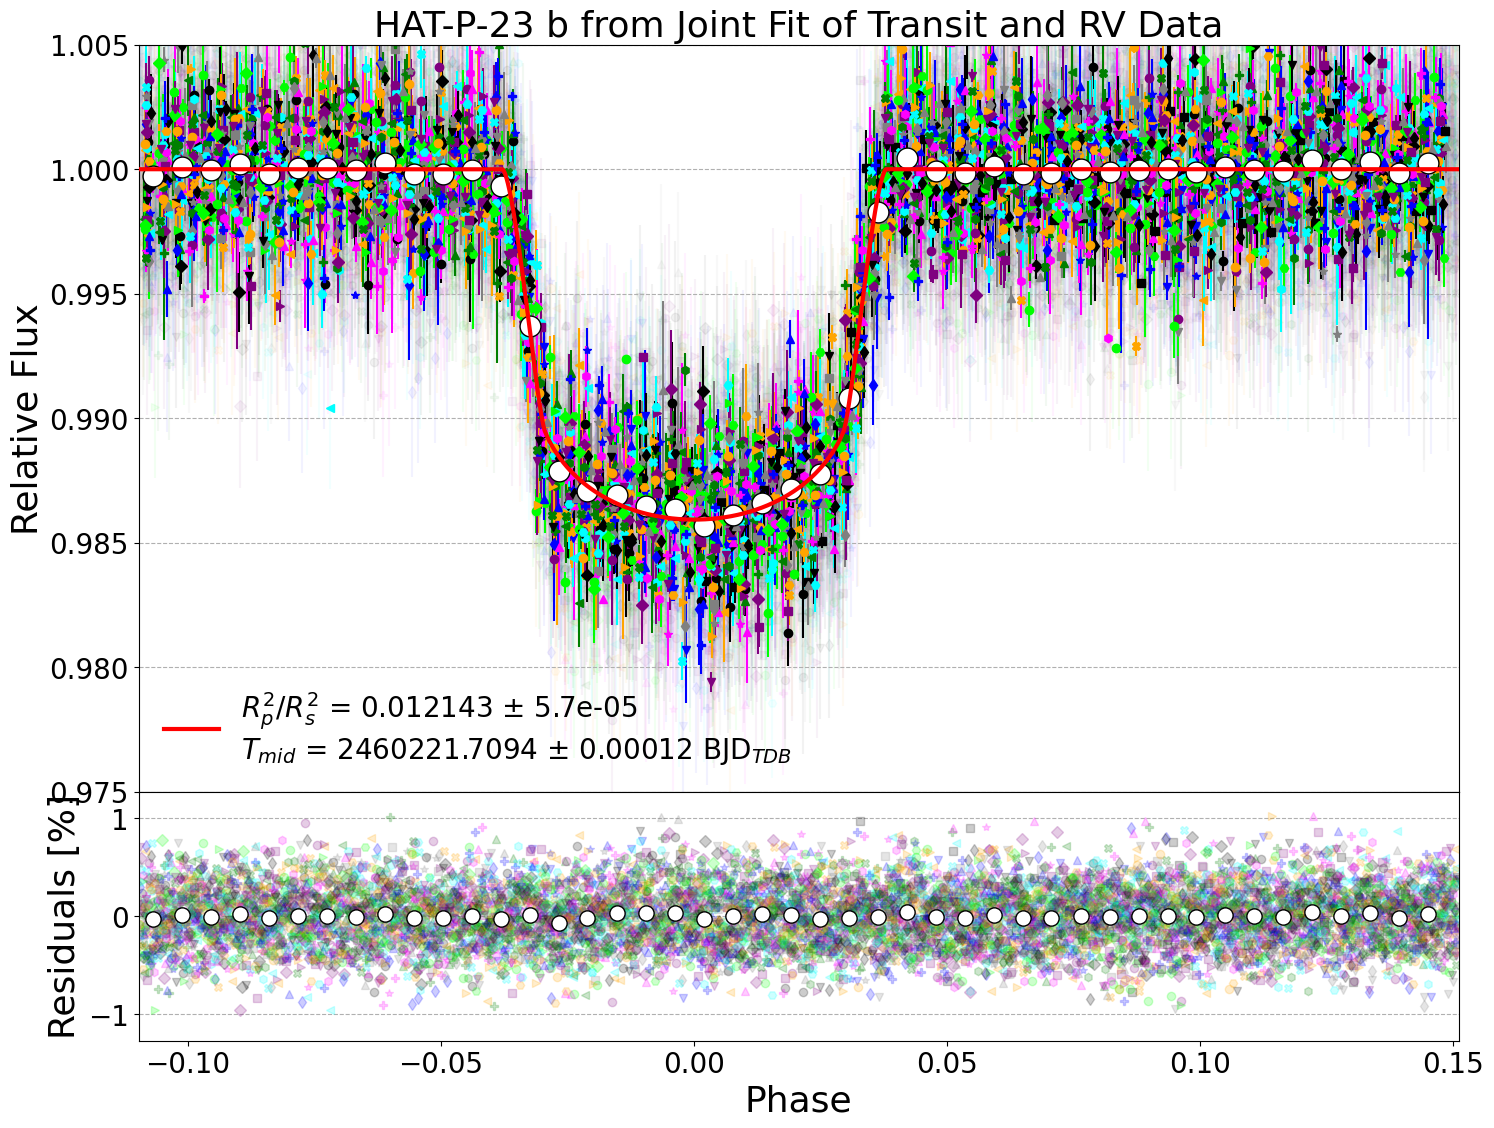

In [11]:
    
    # make some plots
    
transit_title=target_planet + ' from Joint Fit of Transit and RV Data' 
myfit.plot_bestfit(title=transit_title,phase_limits='none',bin_dt=5/(24*60))
plt.savefig("joint_transit_plot.pdf")
plt.show()
plt.close()
    
    

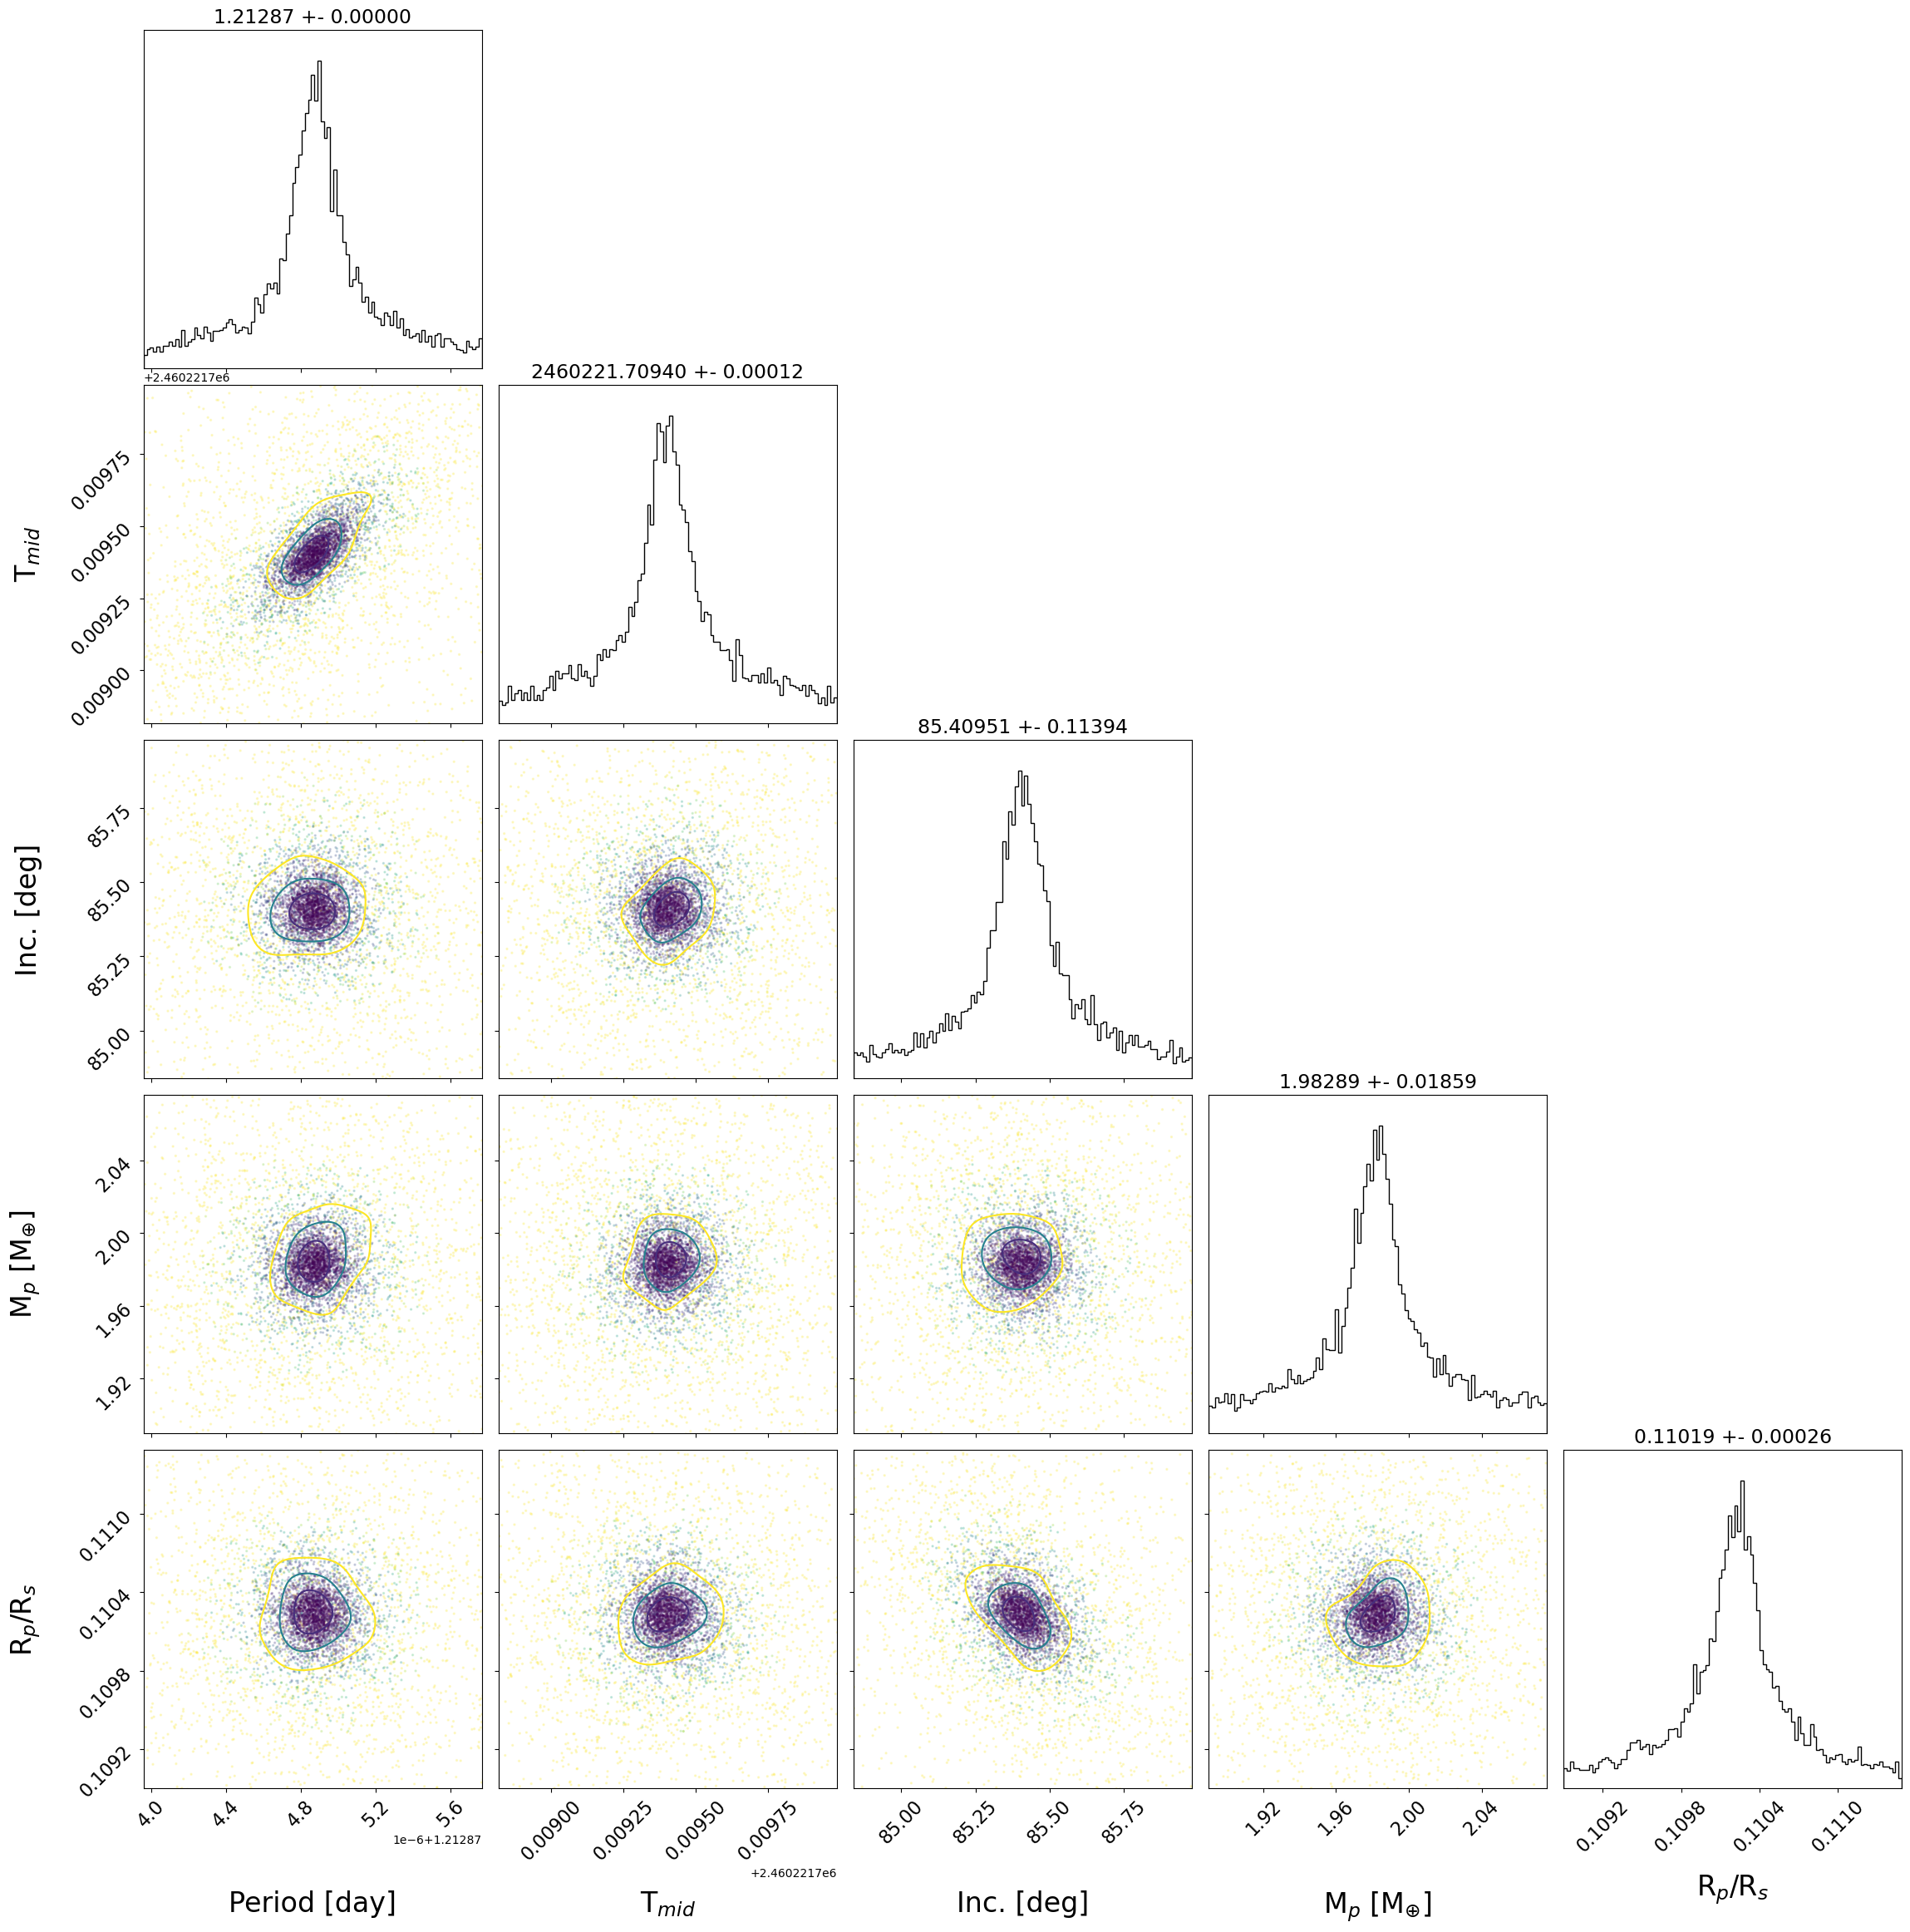

In [12]:
    
#    myfit.plot_bestfits()
#    plt.savefig("tess_individual_lc.pdf",facecolor='white')

myfit.plot_triangle()
plt.savefig("joint_posterior.pdf")
plt.show()
plt.close()
    
    

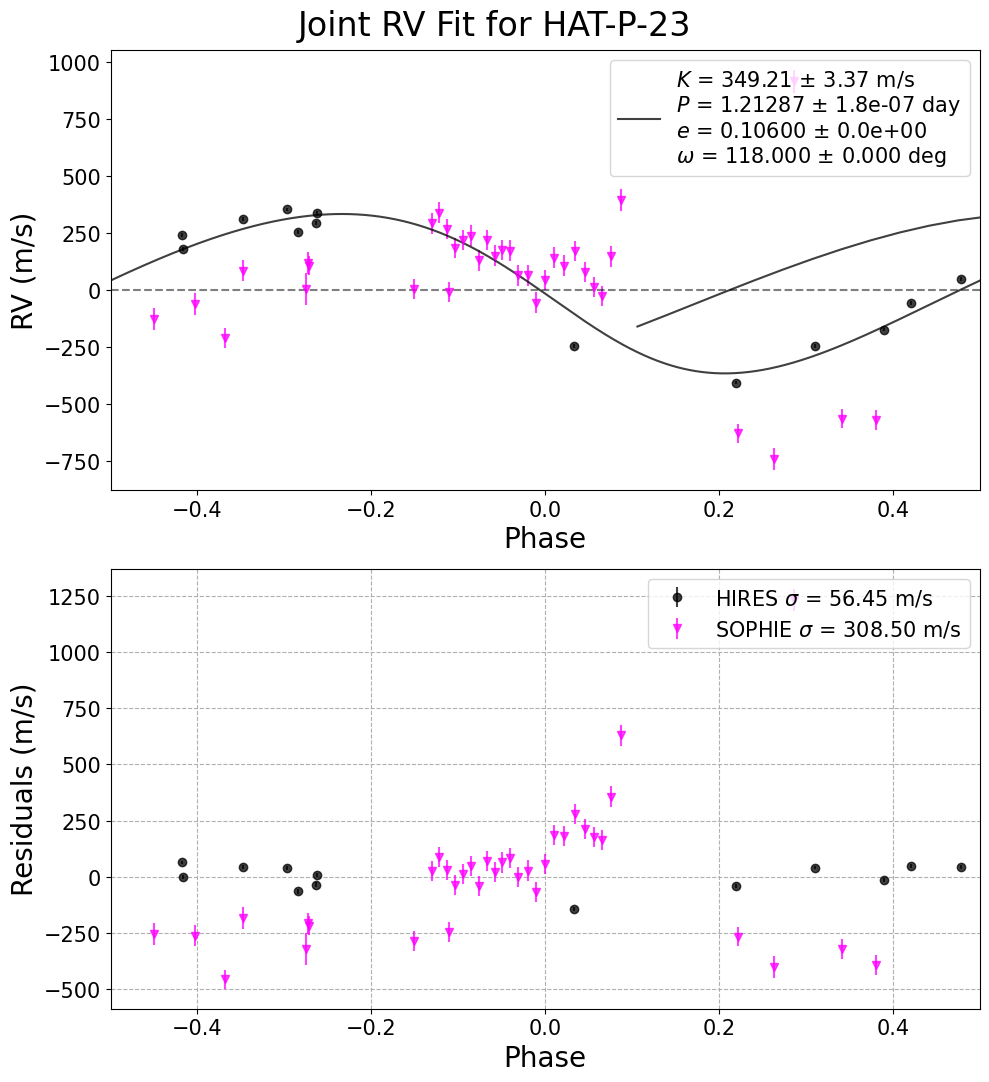

In [13]:
myfit.plot_rv_bestfit()
plt.savefig("joint_rv_fit_plot.pdf")
plt.show()
plt.close()
    
    

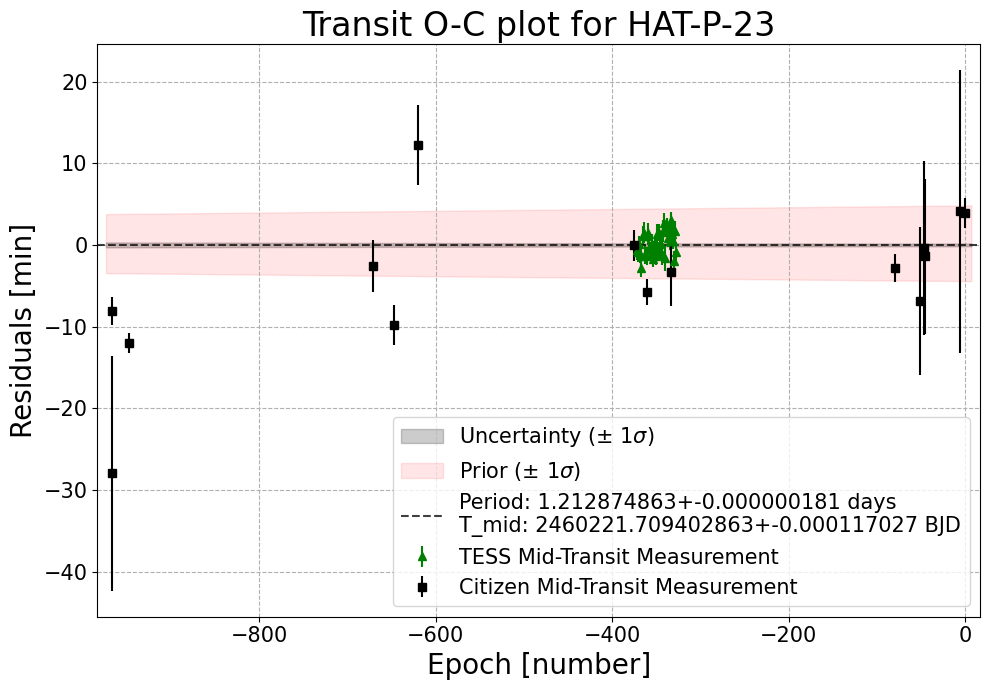

In [14]:
myfit.plot_oc_transits()
plt.savefig("joint_oc_transits_plot.pdf")
plt.show()
plt.close()
    
    

Eclipse Residual [min]: [5.98140255 2.30936989 4.64956708]


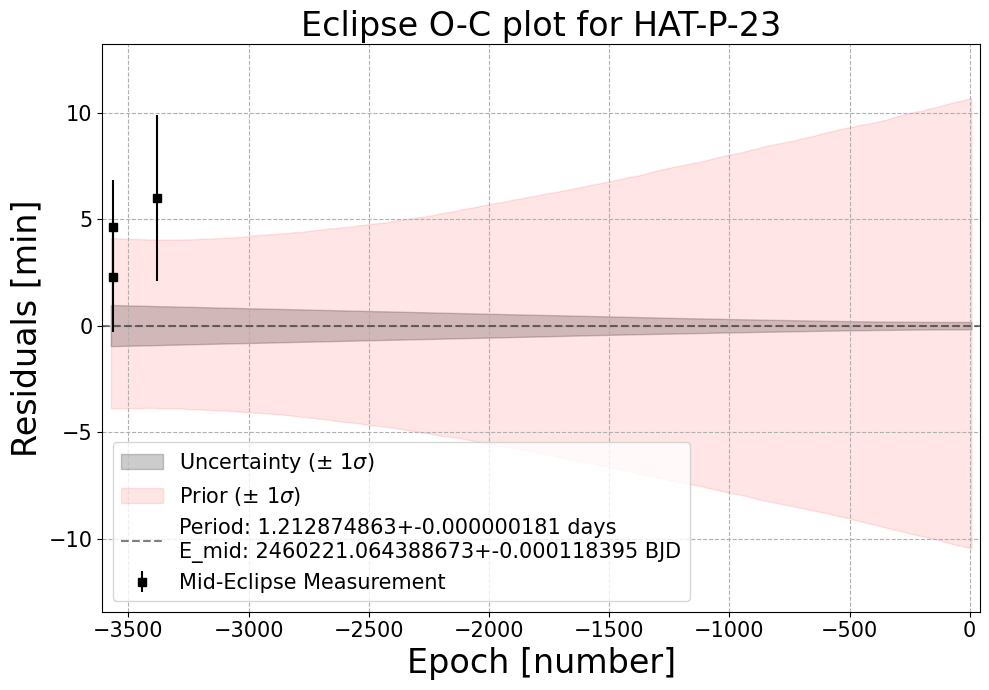

In [15]:
myfit.plot_oc_eclipses()
plt.savefig("joint_oc_eclipse_plot.pdf")
plt.show()
plt.close()
    
    

In [16]:
for key in myfit.errors:
    print(f"{key} & {myfit.parameters[key]:.15f} $\pm$ {myfit.errors[key]:.15f} \\\\")
    line = f"{key} & {myfit.parameters[key]:.15f} $\pm$ {myfit.errors[key]:.15f} \\\\"
    with open(logname, 'a') as joint_log:
        joint_log.write('\n')
        joint_log.write(line)
print()    
for i, data in enumerate(myfit.rv_data):
    print(f"Inflated RV uncertainties for {data['name']} by {data['diff']:2f} m/s")

print()    
#eccfloat = ufloat(myfit.parameters['ecc'],myfit.errors['ecc'])
#omegafloat = ufloat(myfit.parameters['omega'],myfit.errors['omega'])
#esinw = eccfloat*sin(radians(omegafloat.nominal_value))
#ecosw = eccfloat*cos(radians(omegafloat.nominal_value))
    
#print('esinw: & ',esinw)
#print('ecosw: & ',ecosw)

print()
i=0
while i<len(save_myfit_lc_parameters):
    print(f"{i+1} & {save_myfit_lc_parameters[i]['tmid']:.10f} $\pm$ {save_myfit_lc_errors[i]['tmid']:.10f}")
    line = f"{i+1} & {save_myfit_lc_parameters[i]['tmid']:.10f} $\pm$ {save_myfit_lc_errors[i]['tmid']:.10f}"
    with open(logname, 'a') as joint_log:
        joint_log.write('\n')
        joint_log.write(line) 
    i+=1
    

    # Imagine an ancient civilization on mars that had to flee the planet because their atmosphere was deteriorating.
    # There wasn't enough oxygen to sustain their existence. There also wasn't enough resources to save all the people 
    # so only a few were able to flee. They blasted off on their rockets to the next closest planet, Earth.
    # however, at the time it was a cold swamp filled with giant creatures that were able to eat the people. 
    # Their space craft landed near the shore and they set up a colony with all of this futuristic technology 
    # they had brought from mars. This colony would later be destory of natural causes as it was close to the shore 
    # and the Earth was still thawing out of it's last ice age causing the oceans to rise up and flood the planet as the ice melted. 
    # One day a earthquake in the ocean caused a tsunami and it destroyed the coast lines but also created the marianus trench. 
    # The colony lost their original base and it became what is known today as Atlantis. Since 
    # the colony no longer had any futuristic technology to sustain themselves they had to resort to the ways of old and live off the land. 
    # Learn to hunt, gather and farm all over again. This caused the species to regress in evolution to a more primative state. 
    # After generations of primative living they lost memory of what Mars used to be. The stories of space travel and 
    # technology were lost to time and eventually translated into the legends of Gods and other mythical beings that we know today.

    # The End

per & 1.212874863264708 $\pm$ 0.000000180537923 \\
tmid & 2460221.709402862936258 $\pm$ 0.000117026636122 \\
inc & 85.409514034984525 $\pm$ 0.113937066957398 \\
mplanet & 1.982892228696547 $\pm$ 0.018590602625833 \\
rprs & 0.110194643516166 $\pm$ 0.000258486713793 \\
HIRES_offset & 36.980816622456899 $\pm$ 0.834685717034916 \\
SOPHIE_offset & 248.435067945236426 $\pm$ 0.826091778216386 \\
ars & 4.146208537966963 $\pm$ 0.000022273103687 \\
a & 0.023196013896713 $\pm$ 0.000000124607148 \\
mu & 0.001674350324601 $\pm$ 0.000016129502906 \\
emid & 2460221.064388672821224 $\pm$ 0.000118394640446 \\
K & 349.206437717846541 $\pm$ 3.369295752521487 \\
T14 & 2.200035745187741 $\pm$ 0.144860139698803 \\
rprs2 & 0.012142859459655 $\pm$ 0.000056967702560 \\

Inflated RV uncertainties for HIRES by 36.956446 m/s
Inflated RV uncertainties for SOPHIE by 311.346493 m/s




In [17]:
end_time = time.time()
time_lapse = (end_time - start_time)/60
print(f'The time to completion was {time_lapse:.3f} mins.')

The time to completion was 7.794 mins.
